# Reducing Bias in Machine Learning Models - EDA

#### Kristen Lo - BrainStation
---

### Table of Contents
- [Introduction](#intro)
- [Part 1: Preliminary EDA](#eda)
    - 1.1: [Housekeeping](#housekeeping)
    - 1.2: [Disposition vs Demographic](#demo)
    - 1.3: [Disposition vs Triage Categorical Variables](#tcat)
    - 1.4: [Disposition vs Triage Numerical Variables](#tnum)
    - 1.5: [Disposition vs Hospital Usage](#huse)
    - 1.6: [Disposition vs Chief Complaint](#cc)
    - 1.7: [Disposition vs Prior Medical History](#pmh)
    - 1.8: [Miscellaneous Insights](#misc) 
- [Conclusion](#conc)


---
### <a id = 'intro'></a> Introduction

In this notebook, we will be uncovering the early relationships that exist between different columns and their affect on hospital admittance rate for diabetic patients.

There is a need to be able to predict the hospital admission rates for diabetic patients. However, using traditional machine learning models can lead to health disparities caused by biased data which can be related to demographic data (ex. race, age, income, insurance etc). These biases need to be removed prior to modelling so that bias isn't introduced into the model. Building on the work of Raza, S. who aimed to predict, diagnose, and mitigate health disparities in hospital re-admission, my aim is to replicate the study performed by Raza and create my own model that's able to screen for biases and predict admission rates for diabetics visiting the ER. 


Data was sourced from all adult Emergency Department visits from March 2014 - July 2017 from one academic and two community emergency rooms, apart from the Yale New Haven Health system. These visits resulted in either admission to their respective hospital or discharge. 

There are a total of 972 variables that we extracted per patient visit from 560,486 patient visits in the original data set. After cleaning, there are now 476531 patient files being analyzed and 509 features. 

Courtesy of:
 "Hong WS, Haimovich AD, Taylor RA (2018) Predicting hospital admission at emergency department triage using machine learning. PLoS ONE 13(7): e0201016." (https://doi.org/10.1371/journal.pone.0201016)

---
### <a id = 'eda'></a> Part 1: Preliminary EDA

The goal of this Preliminary EDA is to understand the data and the relationship that exists between the features and the target variable (rate of admission). We will first look at the distribution of the various unique occurrences when compared to the whole data set within their respective columns. Then we will look at the admission rates of those unique occurrences compared to their column. Finally, I will perform a phi-coefficient test and their respective p-values to see the significance of the whole column when looking at it's affect on admission rate (the target)

For further EDA, I plan to dummy all of the categorical columns. I will be dropping the first column which would have the most occurrences as this would be my reference column. This way, I can begin to also do further investigation into how each unique occurrence in the dummy column affects disposition (the target). This way, we can begin to understand admission rates and likelihoods based on things like race, religion, etc. 

---
#### <a id = 'housekeeping'></a> 1.1 HouseKeeping 

Loading the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import itertools
from scipy.stats import chi2_contingency

Loading the clean csv file

In [5]:
health_data = pd.read_csv('Data/clean_health_data.csv')

In [6]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None) #Show all rows

In [7]:
health_data.head()

triage_cat_esi demo_age demo_gender           demo_race demo_employstatus  \
0               3    80-89      Female  Hispanic or Latino           Retired   
1               3    80-89      Female  Hispanic or Latino           Retired   
2               4    80-89      Female  Hispanic or Latino           Retired   
3               3    50-59        Male  Hispanic or Latino          Disabled   
4               3    50-59        Male  Hispanic or Latino          Disabled   

  demo_insurance_status  disposition triage_cat_arrivalmonth  \
0              Medicare            0                   April   
1              Medicare            1               September   
2              Medicare            0                   March   
3              Medicare            1                   March   
4              Medicare            1                     May   

  huse_previousdispo  pmh_2ndarymalig  pmh_abdomhernia  pmh_abdomnlpain  \
0              Admit              0.0              0.0              0.0   
1          Discharge              0.0              0.0              0.0   
2              Admit              0.0              0.0              0.0   
3  No previous dispo              0.0              0.0              0.0   
4              Admit              0.0              0.0              0.0   

   pmh_acqfootdef  pmh_acrenlfail  pmh_acutecvd  pmh_acutemi  pmh_acutphanm  \
0             0.0             0.0           0.0          0.0            0.0   
1             0.0             0.0           0.0          0.0            0.0   
2             0.0             0.0           0.0          0.0            0.0   
3             0.0             0.0           0.0          0.0            0.0   
4             0.0             0.0           0.0          0.0            0.0   

   pmh_adjustmentdisorders  pmh_adltrespfl  pmh_alcoholrelateddisorders  \
0                      0.0             0.0                          0.0   
1                      0.0             0.0                          0.0   
2                      0.0             0.0                          0.0   
3                      0.0             0.0                          0.0   
4                      0.0             0.0                          0.0   

   pmh_allergy  pmh_amniosdx  pmh_analrectal  pmh_anemia  pmh_aneurysm  \
0          0.0           0.0             0.0         1.0           0.0   
1          0.0           0.0             0.0         1.0           0.0   
2          0.0           0.0             0.0         1.0           0.0   
3          0.0           0.0             0.0         0.0           0.0   
4          0.0           0.0             0.0         0.0           0.0   

   pmh_anxietydisorders  pmh_appendicitis  pmh_artembolism  pmh_asppneumon  \
0                   0.0               0.0              0.0             0.0   
1                   0.0               0.0              0.0             0.0   
2                   0.0               0.0              0.0             0.0   
3                   0.0               0.0              0.0             0.0   
4                   0.0               0.0              0.0             0.0   

   pmh_asthma  pmh_attentiondeficitconductdisruptivebeha  pmh_backproblem  \
0         0.0                                        0.0              0.0   
1         0.0                                        0.0              0.0   
2         0.0                                        0.0              0.0   
3         0.0                                        0.0              0.0   
4         0.0                                        0.0              0.0   

   pmh_biliarydx  pmh_birthtrauma  pmh_bladdercncr  pmh_blindness  \
0            0.0              0.0              0.0            0.0   
1            0.0              0.0              0.0            0.0   
2            0.0              0.0              0.0            0.0   
3            0.0              0.0              0.0            0.0   
4            0.0              0.0     

---
#### <a id = 'demo'></a> 1.2 Disposition vs Demographic

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `demographic` super-category. 

In [9]:
demographic = health_data.filter(like='demo_').columns
print(f'The columns that make up the demographic super category are : {demographic}')

The columns that make up the demographic super category are : Index(['demo_age', 'demo_gender', 'demo_race', 'demo_employstatus',
       'demo_insurance_status'],
      dtype='object')


First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship to disposition? 

---
What is the distribution?

Here we will look at what kind of unique entries live in the different columns in the `demographic` super column. What are the percentages of each unique entry from the whole?

In [10]:
# Define the list of columns to analyze
columns_of_interest = demographic

In [11]:
for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Print the percentages
    print(f'Percentage Distribution for {column}:')
    print(percentages)
    print('\n')

Percentage Distribution for demo_age:
demo_age
50-59      22.604614
60-69      21.041580
70-79      16.995743
40-49      12.388355
80-89      12.333245
30-39       7.009426
90-99       4.475315
18-29       3.023450
100-109     0.128273
Name: count, dtype: float64


Percentage Distribution for demo_gender:
demo_gender
Female    55.976588
Male      44.023412
Name: count, dtype: float64


Percentage Distribution for demo_race:
demo_race
White or Caucasian                           48.347649
Black or African American                    32.492114
Hispanic or Latino                           18.383946
Asian                                         0.621413
American Indian or Alaska Native              0.098818
Native Hawaiian or Other Pacific Islander     0.056060
Name: count, dtype: float64


Percentage Distribution for demo_employstatus:
demo_employstatus
Retired                    39.966174
Not Employed               21.244917
Disabled                   20.032496
Full Time                 

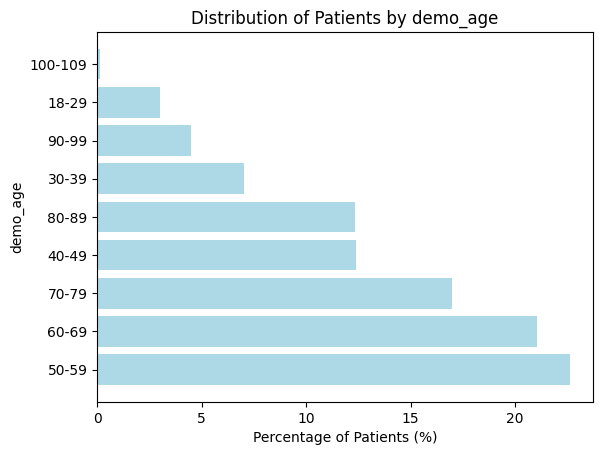

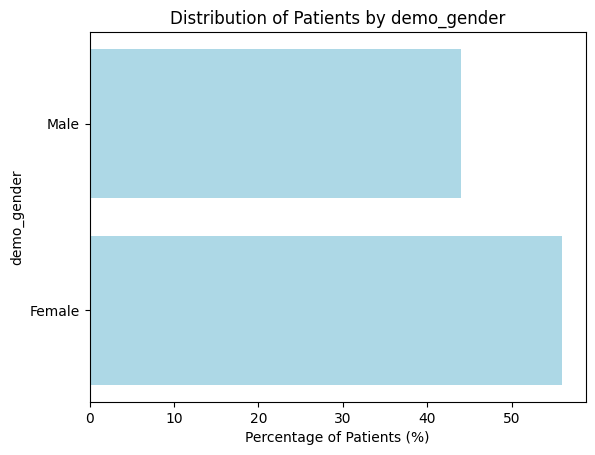

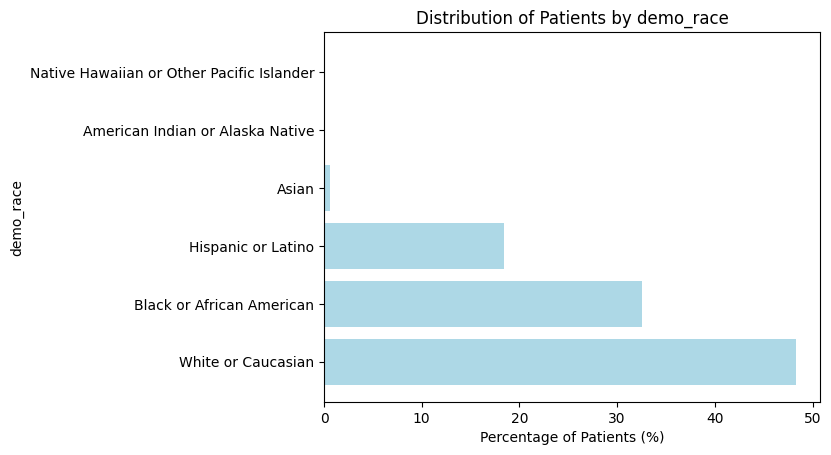

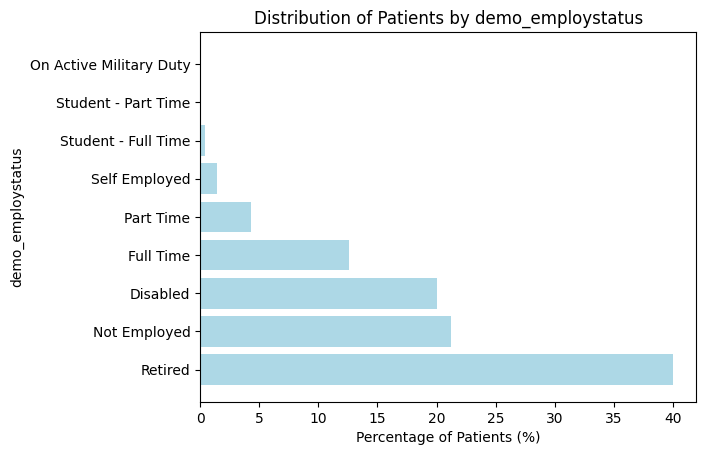

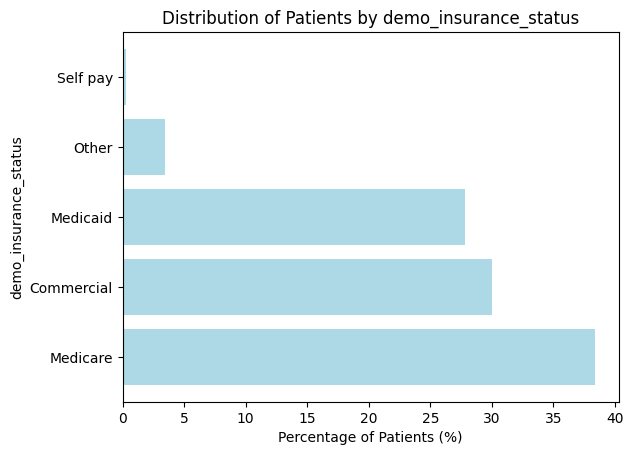

In [12]:

for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Create a bar chart to visualize the distribution by percentage
    plt.figure()
    plt.barh(percentages.index, percentages.values, color='lightblue')
    plt.ylabel(column)
    plt.xlabel('Percentage of Patients (%)')
    plt.title(f'Distribution of Patients by {column}')
    plt.show()

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `demographic` super column and disposition relate to each other. What is the likelihood of getting admitted based on these entries?

In [13]:
#Isolating columns of interest
columns_of_interest = demographic

In [14]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Print the percentages
    print(f'Percentage Admission for {column}:')
    print(column_admission_percentage)
    print('\n')

Percentage Admission for demo_age:
demo_age
100-109     0.078864
18-29       0.724032
30-39       1.805329
40-49       3.762685
50-59       8.666527
60-69      10.048079
70-79       9.858044
80-89       8.041314
90-99       3.025351
dtype: float64


Percentage Admission for demo_gender:
demo_gender
Female    24.822318
Male      21.187906
dtype: float64


Percentage Admission for demo_race:
demo_race
American Indian or Alaska Native              0.049409
Asian                                         0.306906
Black or African American                    13.412641
Hispanic or Latino                            6.540990
Native Hawaiian or Other Pacific Islander     0.019954
White or Caucasian                           25.680324
dtype: float64


Percentage Admission for demo_employstatus:
demo_employstatus
Disabled                9.315495
Full Time               3.432025
Not Employed            7.379043
Part Time               1.095549
Retired                24.159097
Self Employed          

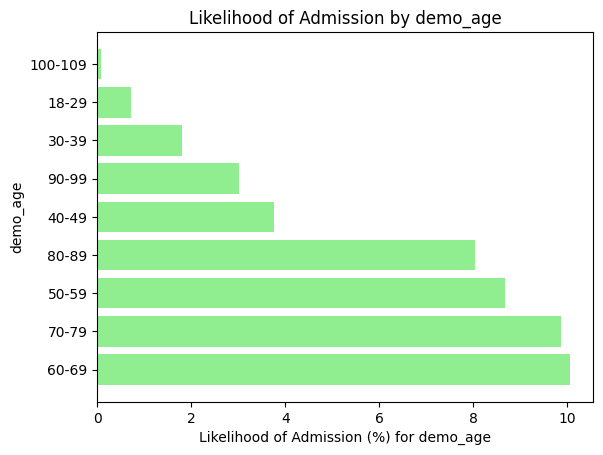

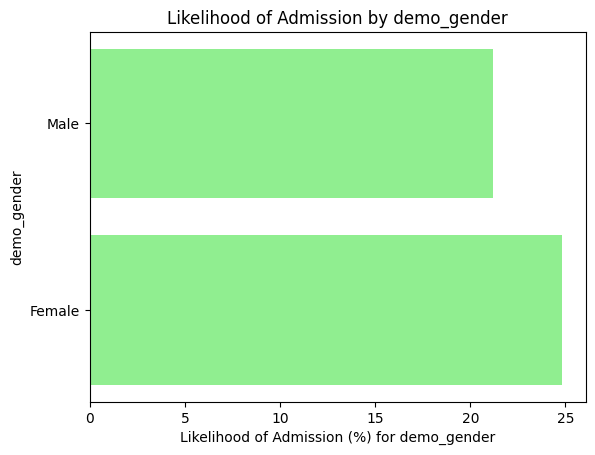

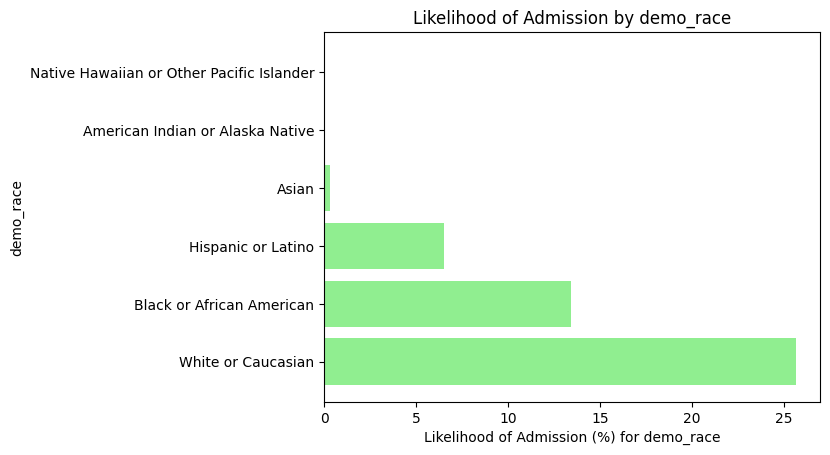

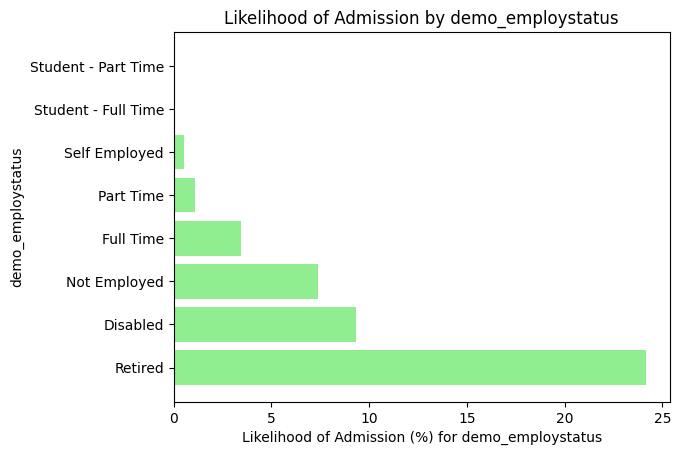

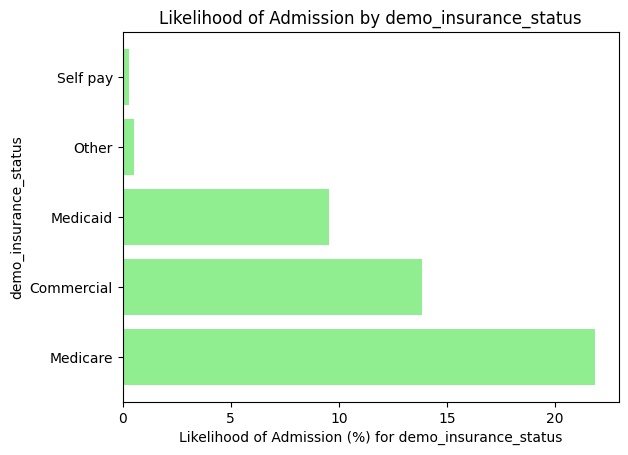

In [15]:

for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Sort the results by admission percentage in descending order
    sorted_results = {k: v for k, v in sorted(column_admission_percentage.items(), key=lambda item: item[1], reverse=True)}
    
    # Extract data for the bar chart
    result = list(sorted_results.keys())
    admission_percentages = list(sorted_results.values())

    # Create and display the bar chart
    plt.figure()
    plt.barh(result, admission_percentages, color='lightgreen')
    plt.xlabel(f'Likelihood of Admission (%) for {column}')
    plt.ylabel(f'{column}')
    plt.title(f'Likelihood of Admission by {column}')
    plt.show()


We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Demographic` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [16]:
#Establishing X and Y
X = health_data[demographic]
Y = health_data['disposition']

In [17]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


               Variable1    ChiSquare       P_Value
0               demo_age  7572.649439  0.000000e+00
1            demo_gender   149.390444  2.356113e-34
2              demo_race  2195.912558  0.000000e+00
3      demo_employstatus  7495.233992  0.000000e+00
4  demo_insurance_status  5291.142811  0.000000e+00


In [18]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

print(sorted_df)

               Variable1    ChiSquare       P_Value
0               demo_age  7572.649439  0.000000e+00
3      demo_employstatus  7495.233992  0.000000e+00
4  demo_insurance_status  5291.142811  0.000000e+00
2              demo_race  2195.912558  0.000000e+00
1            demo_gender   149.390444  2.356113e-34


---
Key takeaways: 

---
#### <a id = 'tcat'></a> 1.3 Disposition vs Triage Categorical Variables

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `triage_cat` super-category. 

In [19]:
triage_cat = health_data.filter(like='triage_cat').columns
print(f'The columns that make up the demographic super category are : {triage_cat}')

The columns that make up the demographic super category are : Index(['triage_cat_esi', 'triage_cat_arrivalmonth'], dtype='object')


First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship to disposition?  
----

What is the distribution?

Here we will look at what kind of unique entries live in the different columns in the `triage_cat` super column. What are the percentages of each unique entry from the whole? What is the distribution?

In [20]:
# Define the list of columns to analyze
columns_of_interest = triage_cat

In [21]:
for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Print the percentages
    print(f'Percentage Distribution for {column}:')
    print(percentages)
    print('\n')

Percentage Distribution for triage_cat_esi:
triage_cat_esi
3    44.677131
2    38.170347
4    13.727148
5     2.254760
1     1.170613
Name: count, dtype: float64


Percentage Distribution for triage_cat_arrivalmonth:
triage_cat_arrivalmonth
May          10.340732
June         10.241914
March        10.062331
April         9.904603
January       7.816123
July          7.669796
August        7.669796
December      7.496864
October       7.430352
September     7.398046
November      7.075938
February      6.893505
Name: count, dtype: float64




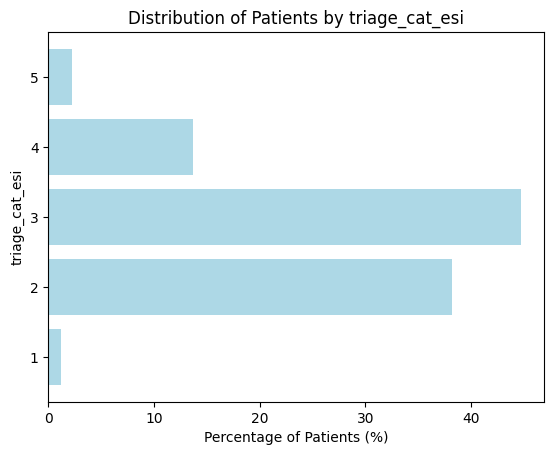

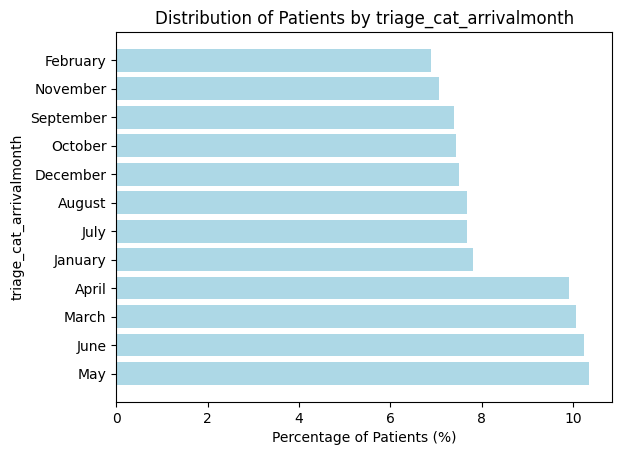

In [22]:

for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Create a bar chart to visualize the distribution by percentage
    plt.figure()
    plt.barh(percentages.index, percentages.values, color='lightblue')
    plt.ylabel(column)
    plt.xlabel('Percentage of Patients (%)')
    plt.title(f'Distribution of Patients by {column}')
    plt.show()

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `triage_cat` super column and disposition relate to each other. What is the likelihood of getting admitted based on these entries?

In [23]:
#Isolating columns of interest
columns_of_interest = triage_cat


In [24]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Print the percentages
    print(f'Percentage Admission for {column}:')
    print(column_admission_percentage)
    print('\n')

Percentage Admission for triage_cat_esi:
triage_cat_esi
1     1.064194
2    25.921668
3    18.414351
4     0.588157
5     0.021854
dtype: float64


Percentage Admission for triage_cat_arrivalmonth:
triage_cat_arrivalmonth
April        4.555129
August       3.481434
December     3.410171
February     3.262894
January      3.634411
July         3.470982
June         4.692904
March        4.765117
May          4.723310
November     3.215385
October      3.432975
September    3.365513
dtype: float64




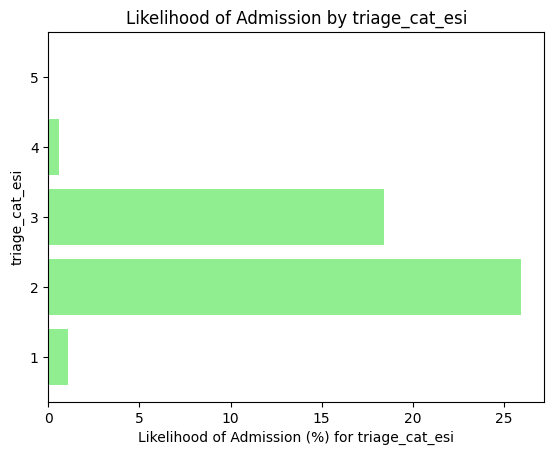

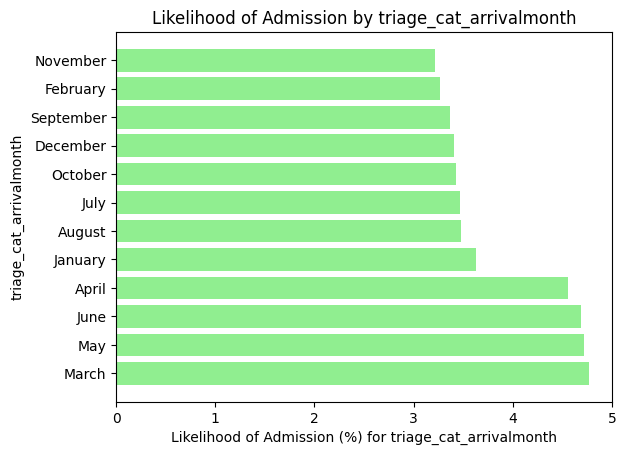

In [25]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Sort the results by admission percentage in descending order
    sorted_results = {k: v for k, v in sorted(column_admission_percentage.items(), key=lambda item: item[1], reverse=True)}

    # Extract data for the bar chart
    result = list(sorted_results.keys())
    admission_percentages = list(sorted_results.values())

    # Create and display the bar chart
    plt.figure()
    plt.barh(result, admission_percentages, color='lightgreen')
    plt.xlabel(f'Likelihood of Admission (%) for {column}')
    plt.ylabel(f'{column}')
    plt.title(f'Likelihood of Admission by {column}')
    plt.show()

We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Triage Categorical` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [26]:
#Establishing X and Y
X = health_data[triage_cat]
Y = health_data['disposition']

In [27]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


                 Variable1     ChiSquare   P_Value
0           triage_cat_esi  21254.589575  0.000000
1  triage_cat_arrivalmonth     20.157753  0.043224


In [28]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

print(sorted_df)

                 Variable1     ChiSquare   P_Value
0           triage_cat_esi  21254.589575  0.000000
1  triage_cat_arrivalmonth     20.157753  0.043224


---
Key takeaways: 

---
#### <a id = 'tnum'></a> 1.4 Disposition vs Triage Numerical Variables

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `Triage Numerical` super-category. 

In [29]:
triage_num = health_data.filter(like='triage_vita').columns
print(f'The columns that make up the demographic super category are : {triage_num}')

The columns that make up the demographic super category are : Index(['triage_vital_hr', 'triage_vital_sbp', 'triage_vital_dbp',
       'triage_vital_rr', 'triage_vital_temp', 'triage_vital_hr_imputed_flag',
       'triage_vital_sbp_imputed_flag', 'triage_vital_dbp_imputed_flag',
       'triage_vital_rr_imputed_flag', 'triage_vital_temp_imputed_flag'],
      dtype='object')


We previously converted these numerical columns into categorical columns for understandability. So even though these columns are categorical, we will still consider them to be numeric. 

We will not be looking into the imputed_flag as it will not provide any meaningful data given that these just indicate whether or not the numerical data was imputed or not. This will come into play for modelling.

In [30]:
triage_num = ['triage_vital_hr', 'triage_vital_sbp', 'triage_vital_dbp',
       'triage_vital_rr', 'triage_vital_temp'
      ]

First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship to disposition? 
______

What is the distribution?

Here we will look at what kind of unique entries live in the different columns in the `triage_vital` super column. What are the percentages of each unique entry from the whole? What is the distribution?

In [31]:
# Define the list of columns to analyze
columns_of_interest = triage_num

In [32]:
for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Print the percentages
    print(f'Percentage Distribution for {column}:')
    print(percentages)
    print('\n')

Percentage Distribution for triage_vital_hr:
triage_vital_hr
normal_hr               85.919387
tachycardia(high)_hr    11.697579
bradycardia(low)_hr      2.342176
critical_hr              0.040857
Name: count, dtype: float64


Percentage Distribution for triage_vital_sbp:
triage_vital_sbp
hypertension(high)_sbp    48.470222
pre-hypertension_sbp      33.861313
normal_sbp                13.507658
critical_sbp               3.563148
hypotension(low)_sbp       0.597659
Name: count, dtype: float64


Percentage Distribution for triage_vital_dbp:
triage_vital_dbp
normal_dbp                51.877542
pre-hypertension_dbp      28.905211
hypertension(high)_dbp    13.865874
hypotension(low)_dbp       4.606438
critical_dpb               0.744936
Name: count, dtype: float64


Percentage Distribution for triage_vital_rr:
triage_vital_rr
normal_rr             97.351868
tachypnea(high)_rr     2.485652
Critical_rr            0.137775
bradypnea(low)_rr      0.024704
Name: count, dtype: float64


Percenta

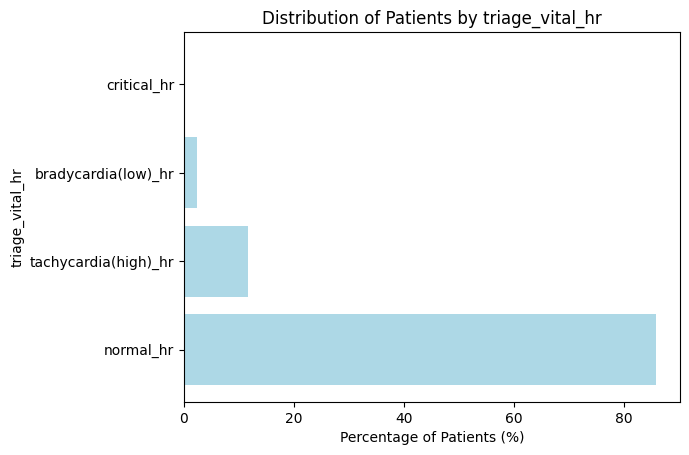

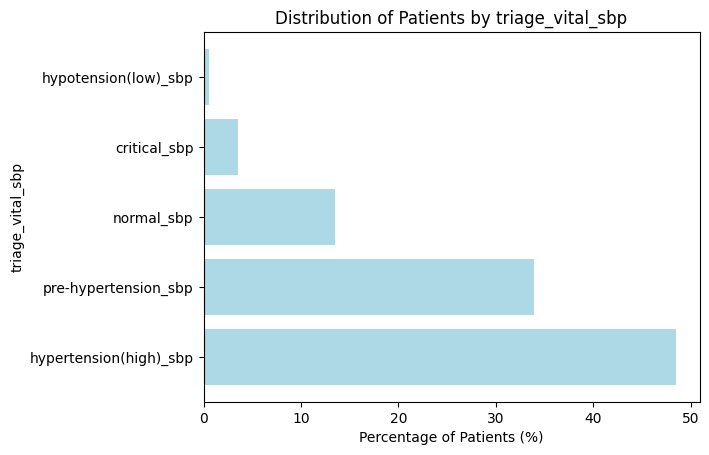

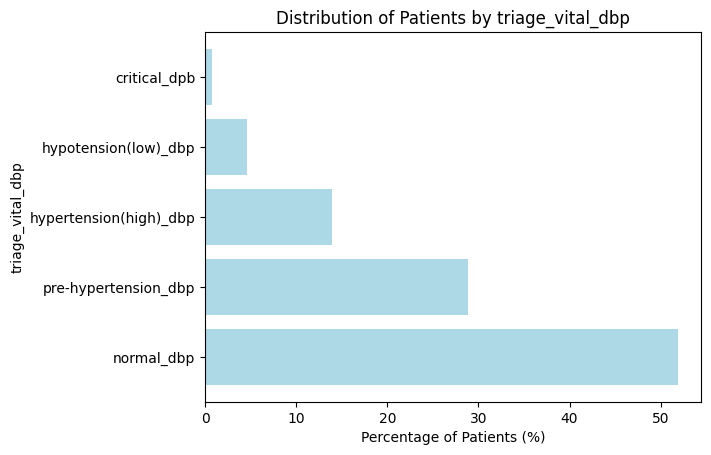

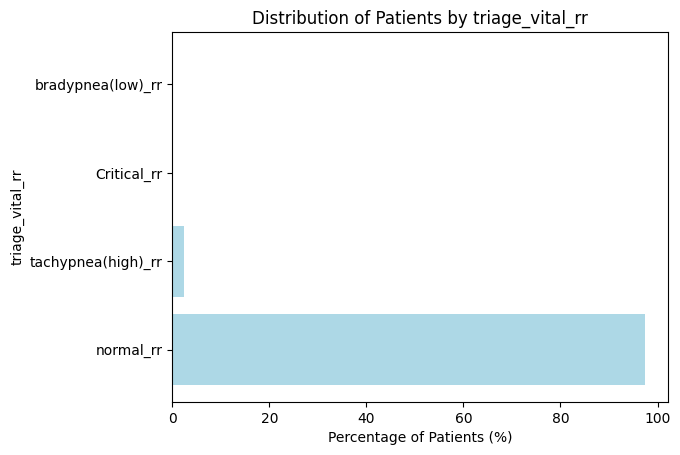

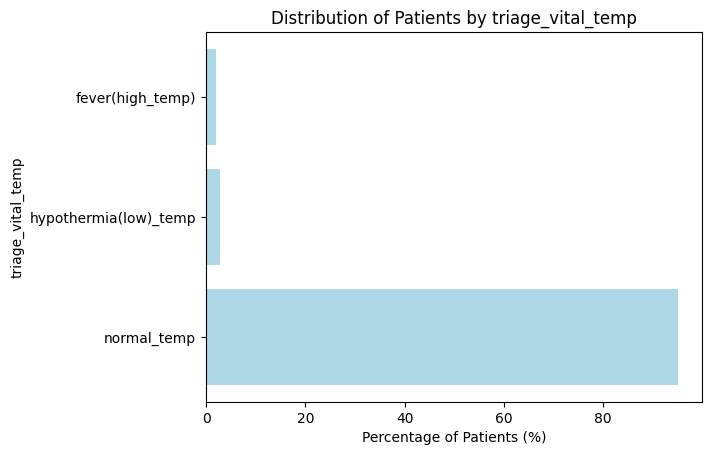

In [33]:

for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Create a bar chart to visualize the distribution by percentage
    plt.figure()
    plt.barh(percentages.index, percentages.values, color='lightblue')
    plt.ylabel(column)
    plt.xlabel('Percentage of Patients (%)')
    plt.title(f'Distribution of Patients by {column}')
    plt.show()

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `triage_vital` super column and disposition relate to each other. What is the likelihood of getting admitted based on these entries?

In [34]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Print the percentages
    print(f'Percentage Admission for {column}:')
    print(column_admission_percentage)
    print('\n')

Percentage Admission for triage_vital_hr:
triage_vital_hr
bradycardia(low)_hr      1.093649
critical_hr              0.032306
normal_hr               39.081563
tachycardia(high)_hr     5.802706
dtype: float64


Percentage Admission for triage_vital_sbp:
triage_vital_sbp
critical_sbp               1.642849
hypertension(high)_sbp    24.851773
hypotension(low)_sbp       0.479837
normal_sbp                 5.864467
pre-hypertension_sbp      13.171297
dtype: float64


Percentage Admission for triage_vital_dbp:
triage_vital_dbp
critical_dpb               0.444681
hypertension(high)_dbp     4.776519
hypotension(low)_dbp       2.842917
normal_dbp                27.223405
pre-hypertension_dbp      10.722702
dtype: float64


Percentage Admission for triage_vital_rr:
triage_vital_rr
Critical_rr            0.114021
bradypnea(low)_rr      0.016153
normal_rr             44.321767
tachypnea(high)_rr     1.558284
dtype: float64


Percentage Admission for triage_vital_temp:
triage_vital_temp
fever(high

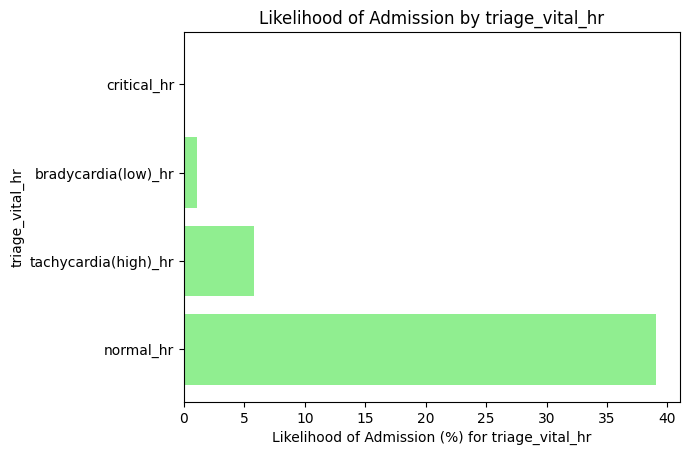

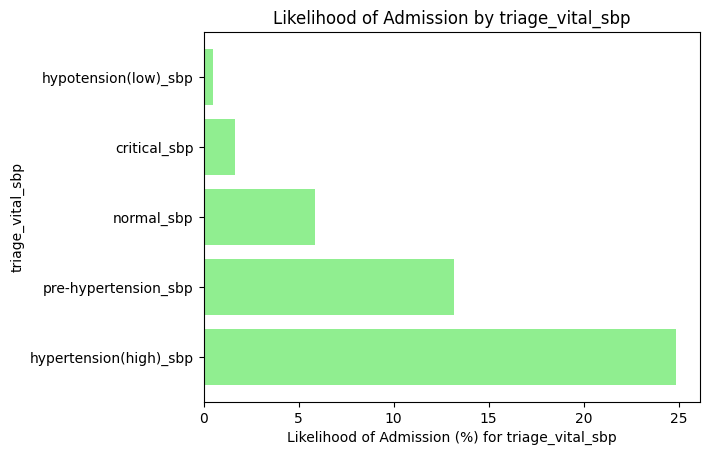

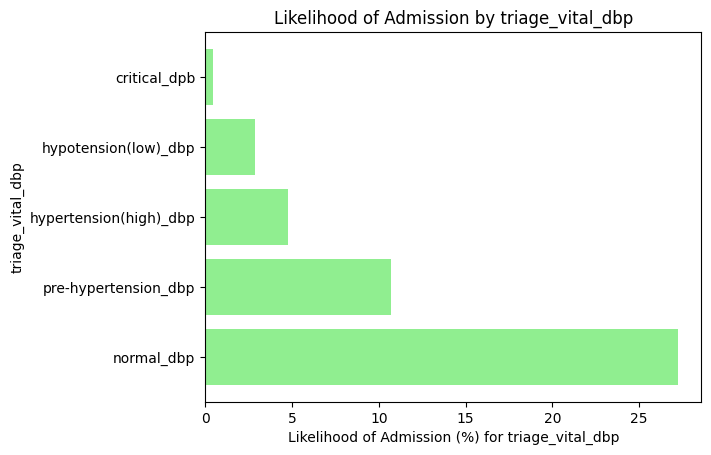

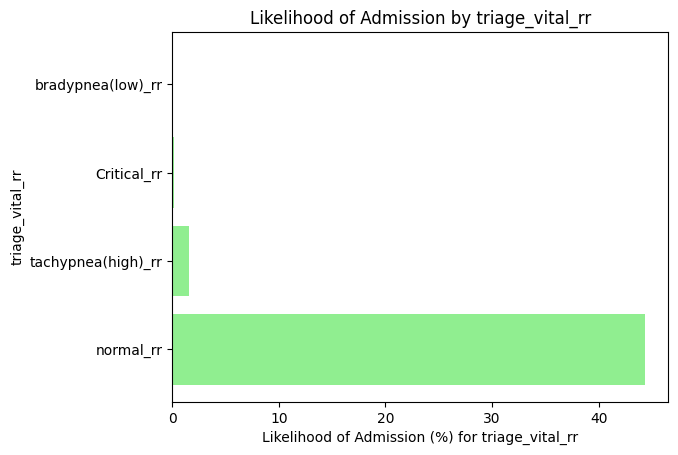

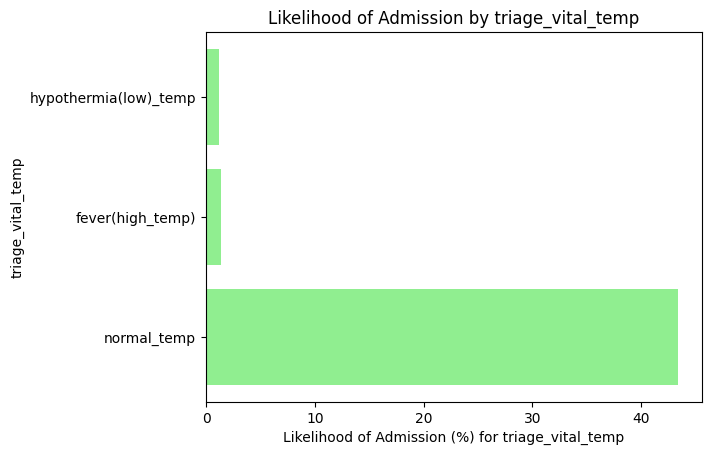

In [35]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Sort the results by admission percentage in descending order
    sorted_results = {k: v for k, v in sorted(column_admission_percentage.items(), key=lambda item: item[1], reverse=True)}

    # Extract data for the bar chart
    result = list(sorted_results.keys())
    admission_percentages = list(sorted_results.values())

    # Create and display the bar chart
    plt.figure()
    plt.barh(result, admission_percentages, color='lightgreen')
    plt.xlabel(f'Likelihood of Admission (%) for {column}')
    plt.ylabel(f'{column}')
    plt.title(f'Likelihood of Admission by {column}')
    plt.show()

We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Triage Numerical` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [36]:
#Establishing X and Y
X = health_data[triage_num]
Y = health_data['disposition']

In [37]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


           Variable1    ChiSquare        P_Value
0    triage_vital_hr    93.454186   3.967305e-20
1   triage_vital_sbp  1630.351461   0.000000e+00
2   triage_vital_dbp  3217.926088   0.000000e+00
3    triage_vital_rr   385.401370   3.214956e-83
4  triage_vital_temp   473.448589  1.555769e-103


In [38]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

print(sorted_df)

           Variable1    ChiSquare        P_Value
2   triage_vital_dbp  3217.926088   0.000000e+00
1   triage_vital_sbp  1630.351461   0.000000e+00
4  triage_vital_temp   473.448589  1.555769e-103
3    triage_vital_rr   385.401370   3.214956e-83
0    triage_vital_hr    93.454186   3.967305e-20


---
Key takeaways: 

---
#### <a id = 'huse'></a> 1.5 Disposition vs Hospital Usage

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `Hospital Usage` super-category. 

In [39]:
hos_usage = health_data.filter(like='huse_').columns
print(f'The columns that make up the demographic super category are : {hos_usage}')

The columns that make up the demographic super category are : Index(['huse_previousdispo', 'huse_n_edvisits', 'huse_n_admissions',
       'huse_n_surgeries'],
      dtype='object')


First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship to disposition? 
____

What is the distribution?

Here we will look at what kind of unique entries live in the different columns in the `Hospital Usage` super column. What are the percentages of each unique entry from the whole? What is the distribution?

In [40]:
# Define the list of columns to analyze
columns_of_interest = hos_usage

In [41]:
for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Print the percentages
    print(f'Percentage Distribution for {column}:')
    print(percentages)
    print('\n')

Percentage Distribution for huse_previousdispo:
huse_previousdispo
Discharge                       42.818593
Admit                           36.896165
No previous dispo               17.649462
Transfer to Another Facility     1.025237
LWBS after Triage                0.612862
AMA                              0.602410
Eloped                           0.220440
LWBS before Triage               0.095967
Observation                      0.070313
Send to L&D                      0.008552
Name: count, dtype: float64


Percentage Distribution for huse_n_edvisits:
huse_n_edvisits
low_prior_visit         63.096234
no_prior_visits         25.983429
moderate_prior_visit     9.904603
high_prior_visit         1.015735
Name: count, dtype: float64


Percentage Distribution for huse_n_admissions:
huse_n_admissions
low_prior_admis         49.278819
No_prior_admis          47.994185
moderate_prior_admis     2.323173
high_prior_admis         0.266048
vhigh_prior_admis        0.137775
Name: count, dtype: f

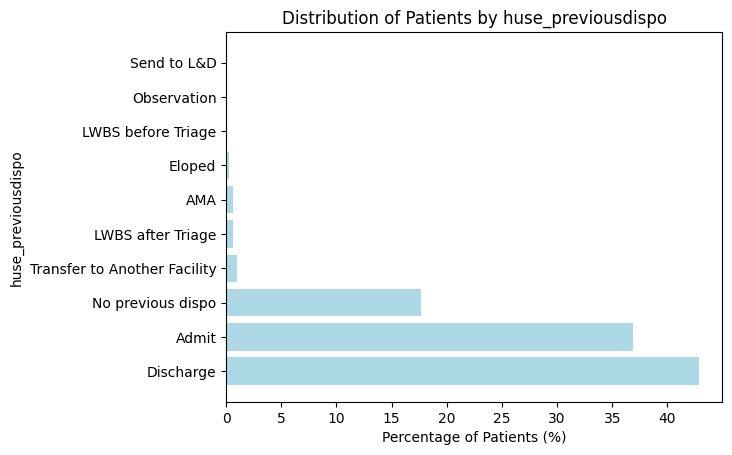

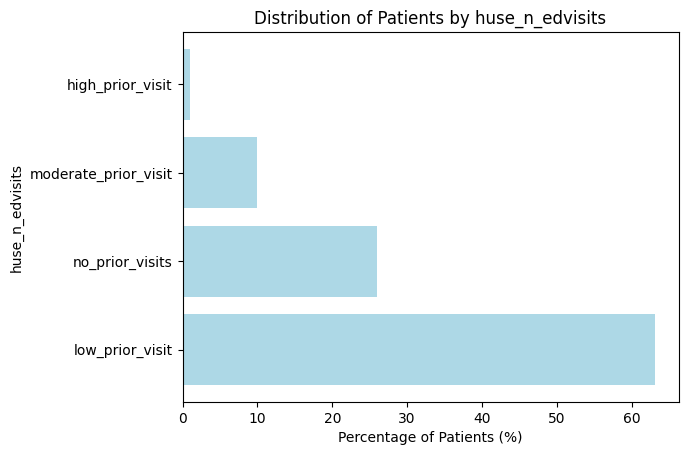

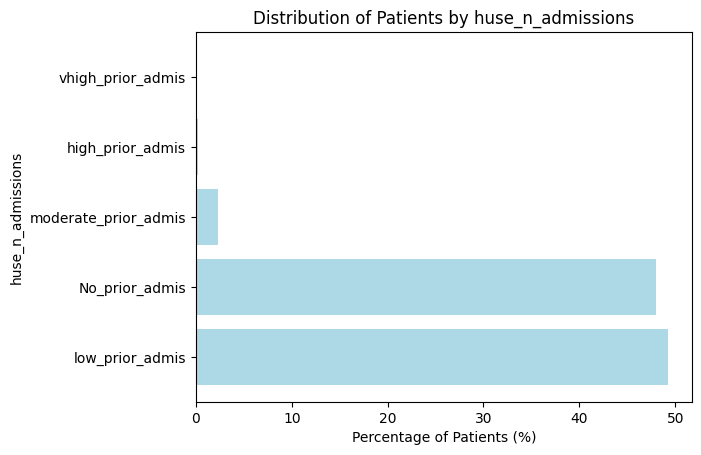

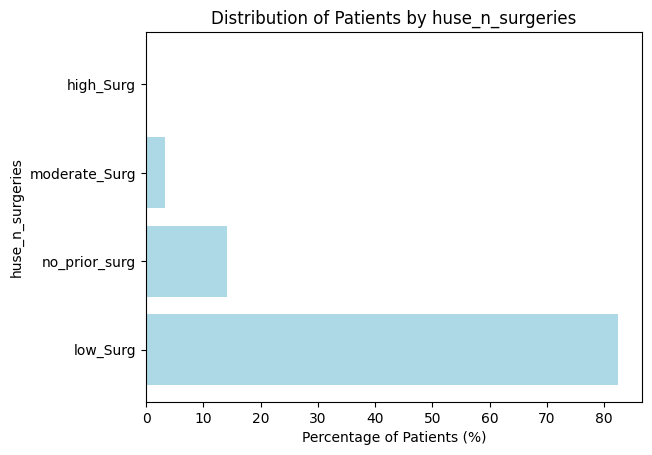

In [42]:

for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Create a bar chart to visualize the distribution by percentage
    plt.figure()
    plt.barh(percentages.index, percentages.values, color='lightblue')
    plt.ylabel(column)
    plt.xlabel('Percentage of Patients (%)')
    plt.title(f'Distribution of Patients by {column}')
    plt.show()

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `hospital usage` super column and disposition relate to each other. What is the likelihood of getting admitted based on these entries?

In [43]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Print the percentages
    print(f'Percentage Admission for {column}:')
    print(column_admission_percentage)
    print('\n')

Percentage Admission for huse_previousdispo:
huse_previousdispo
AMA                              0.269849
Admit                           23.243130
Discharge                       13.806963
Eloped                           0.063662
LWBS after Triage                0.188134
LWBS before Triage               0.026605
No previous dispo                7.931093
Observation                      0.034206
Send to L&D                      0.001900
Transfer to Another Facility     0.444681
dtype: float64


Percentage Admission for huse_n_edvisits:
huse_n_edvisits
high_prior_visit         0.188134
low_prior_visit         30.066322
moderate_prior_visit     4.029683
no_prior_visits         11.726084
dtype: float64


Percentage Admission for huse_n_admissions:
huse_n_admissions
No_prior_admis          17.420471
high_prior_admis         0.160579
low_prior_admis         26.983961
moderate_prior_admis     1.372050
vhigh_prior_admis        0.073163
dtype: float64


Percentage Admission for huse_n_surgeri

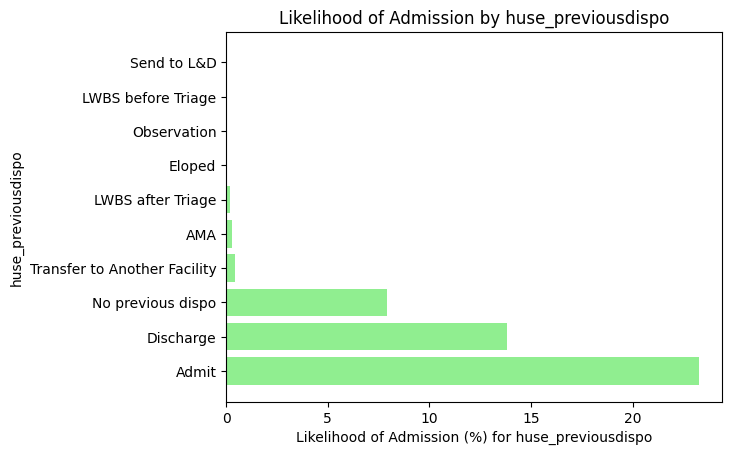

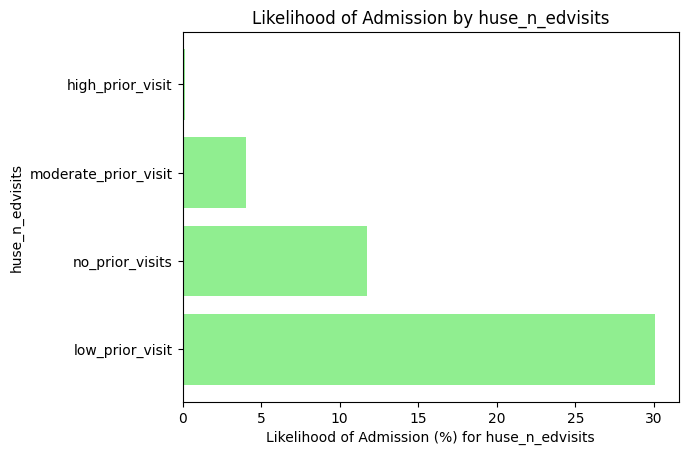

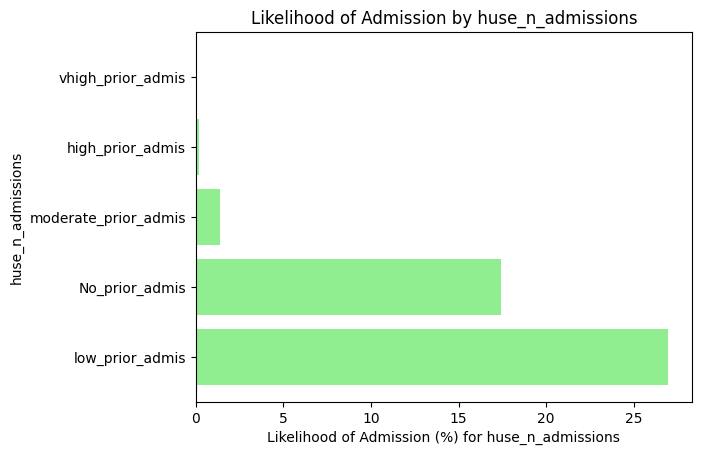

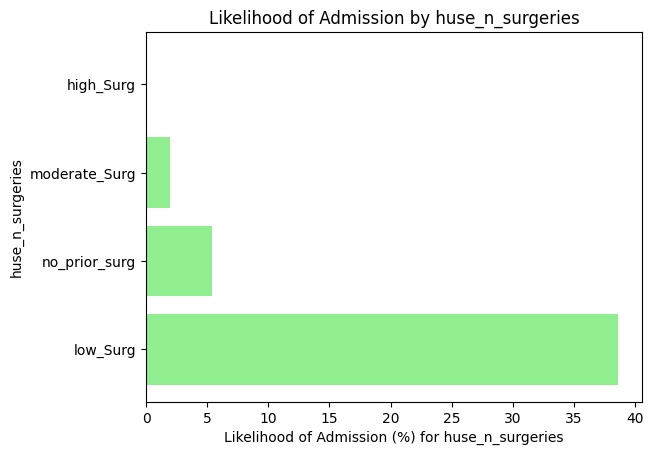

In [44]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Sort the results by admission percentage in descending order
    sorted_results = {k: v for k, v in sorted(column_admission_percentage.items(), key=lambda item: item[1], reverse=True)}

    # Extract data for the bar chart
    result = list(sorted_results.keys())
    admission_percentages = list(sorted_results.values())

    # Create and display the bar chart
    plt.figure()
    plt.barh(result, admission_percentages, color='lightgreen')
    plt.xlabel(f'Likelihood of Admission (%) for {column}')
    plt.ylabel(f'{column}')
    plt.title(f'Likelihood of Admission by {column}')
    plt.show()

We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Hospital Usage` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [45]:
#Establishing X and Y
X = health_data[hos_usage]
Y = health_data['disposition']

In [46]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


            Variable1    ChiSquare        P_Value
0  huse_previousdispo  8063.540504   0.000000e+00
1     huse_n_edvisits   524.728349  2.086504e-113
2   huse_n_admissions  3709.724574   0.000000e+00
3    huse_n_surgeries   609.878771  7.274107e-132


In [47]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

print(sorted_df)

            Variable1    ChiSquare        P_Value
0  huse_previousdispo  8063.540504   0.000000e+00
2   huse_n_admissions  3709.724574   0.000000e+00
3    huse_n_surgeries   609.878771  7.274107e-132
1     huse_n_edvisits   524.728349  2.086504e-113


---
Key takeaways: 

---
#### <a id = 'cc'></a> 1.6 Disposition vs Chief Complaint

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `Chief Complaint` super-category. 

In [48]:
chief_complaint = health_data.filter(like='cc_').columns
print(f'The columns that make up the demographic super category are : {chief_complaint}')

The columns that make up the demographic super category are : Index(['cc_abdominalcramping', 'cc_abdominaldistention', 'cc_abdominalpain',
       'cc_abdominalpainpregnant', 'cc_abnormallab', 'cc_abscess',
       'cc_addictionproblem', 'cc_agitation', 'cc_alcoholintoxication',
       'cc_alcoholproblem',
       ...
       'cc_vaginaldischarge', 'cc_vaginalpain', 'cc_weakness', 'cc_wheezing',
       'cc_withdrawal-alcohol', 'cc_woundcheck', 'cc_woundinfection',
       'cc_woundre-evaluation', 'cc_wristinjury', 'cc_wristpain'],
      dtype='object', length=200)


First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship to disposition? 
____

What is the distribution?

Here we will look at what kind of unique entries live in the different columns in the `Chief Complaint` super column. What are the percentages of each unique entry from the whole? What is the distribution?

Given that there are 200 columns, it may be difficult to create an appropriate visual to really understand this. It may be easier just to create a list of percentages. 



In [49]:
# Define the group of columns you want to analyze ('chief_complaint' columns)
chief_complaint_columns = health_data.filter(like='cc_')

# Create an empty dictionary to store the results
percentage_results = {}

# Loop through each column in the group
for column_name in chief_complaint_columns.columns:
    # Calculate the percentage of 1s in the current column
    percentage = (chief_complaint_columns[column_name] == 1).sum() / len(health_data) * 100
    # Store the result in the dictionary
    percentage_results[column_name] = percentage

# Convert the results to a DataFrame for easier analysis
results_df = pd.DataFrame(percentage_results.items(), columns=['Variable', 'Percentage of Occurrence'])

# Sort the results by the percentage in descending order
results_df = results_df.sort_values(by='Percentage of Occurrence', ascending=False)

In [50]:
top_20 = results_df.head(20)
print(top_20)

                              Variable  Percentage of Occurrence
2                     cc_abdominalpain                  9.071301
31                        cc_chestpain                  8.522101
142                           cc_other                  8.339668
163               cc_shortnessofbreath                  6.793736
71                             cc_fall                  3.972673
21                         cc_backpain                  3.301851
46                        cc_dizziness                  2.852419
11              cc_alteredmentalstatus                  2.575919
119                         cc_legpain                  2.345977
38                            cc_cough                  2.340276
57                           cc_emesis                  2.245259
192                        cc_weakness                  2.244308
72                          cc_fall>65                  1.956406
8               cc_alcoholintoxication                  1.956406
82                       

In [51]:
bottom_20 = results_df.tail(20)
print(bottom_20)

                    Variable  Percentage of Occurrence
190      cc_vaginaldischarge                  0.048459
0       cc_abdominalcramping                  0.047509
155        cc_rectalbleeding                  0.046558
68       cc_faciallaceration                  0.046558
148            cc_pelvicpain                  0.044658
131       cc_motorcyclecrash                  0.043708
194    cc_withdrawal-alcohol                  0.043708
175  cc_swallowedforeignbody                  0.042758
30             cc_cellulitis                  0.042758
183                cc_trauma                  0.038007
179           cc_thumbinjury                  0.035156
180           cc_tickremoval                  0.031356
36         cc_conjunctivitis                  0.031356
171              cc_stdcheck                  0.030406
166        cc_sicklecellpain                  0.024704
24      cc_bodyfluidexposure                  0.021854
87       cc_foreignbodyineye                  0.018053
162       

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `Chief Complaint` super column and disposition relate to each other. What is the likelihood of getting admitted based on these entries? We will be using phi coefficients as it measures the strength and direction of the association between two binary variables. Given that the target variable, disposition, is binary and so are the `Chief Complaint` columns, it was decided that this would be the best one to use. We will look at the coefficient to determine the relationship that exists between the given `Chief Complaint` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [52]:
#Establishing X and Y
X = health_data[chief_complaint]
Y = health_data['disposition']

In [53]:
# Create an empty list to store the results
results = []

# Generate all pairwise combinations of binary columns from X and Y
binary_columns_X = X.columns.tolist()
binary_columns_Y = ['disposition']
combinations = list(itertools.product(binary_columns_X, binary_columns_Y))

# Calculate Phi coefficients and p-values for each combination
for var1, var2 in combinations:
    contingency_table = pd.crosstab(health_data[var1], health_data[var2])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    n = len(health_data)
    phi_coefficient = np.sqrt(chi2 / (n * min(contingency_table.shape) - 1))
    results.append((var1, phi_coefficient, p))

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Variable1', 'Phi_Coefficient', 'P_Value'])

# Display the DataFrame
print(results_df)

                                   Variable1  Phi_Coefficient        P_Value
0                       cc_abdominalcramping         0.004643   3.316642e-02
1                     cc_abdominaldistention         0.013687   3.397275e-10
2                           cc_abdominalpain         0.015391   1.650472e-12
3                   cc_abdominalpainpregnant         0.014759   1.275109e-11
4                             cc_abnormallab         0.047232  3.971203e-104
5                                 cc_abscess         0.024189   1.290552e-28
6                        cc_addictionproblem         0.008348   1.281268e-04
7                               cc_agitation         0.001461   5.026696e-01
8                     cc_alcoholintoxication         0.058289  1.520231e-157
9                          cc_alcoholproblem         0.017684   4.926578e-16
10                       cc_allergicreaction         0.018071   1.126784e-16
11                    cc_alteredmentalstatus         0.088513   0.000000e+00

In [54]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='P_Value', ascending=True)

sorted_df.head(20)

Variable1  Phi_Coefficient        P_Value
163      cc_shortnessofbreath         0.114308   0.000000e+00
11     cc_alteredmentalstatus         0.088513   0.000000e+00
31               cc_chestpain         0.072365  1.062888e-241
132      cc_motorvehiclecrash         0.064004  1.574794e-189
192               cc_weakness         0.061591  1.165641e-175
8      cc_alcoholintoxication         0.058289  1.520231e-157
21                cc_backpain         0.057816  4.947683e-155
172            cc_strokealert         0.050281  9.607920e-118
4              cc_abnormallab         0.047232  3.971203e-104
116               cc_kneepain         0.044712   1.633411e-93
77   cc_fever-9weeksto74years         0.044470   1.591978e-92
154                   cc_rash         0.044003   1.241839e-90
170             cc_sorethroat         0.040630   1.501810e-77
90              cc_gibleeding         0.039591   9.981592e-74
26     cc_breathingdifficulty         0.039337   8.291232e-73
57                  cc_emesis         0.039152   3.834235e-72
73                 cc_fatigue         0.038115   1.813658e-68
108            cc_hypotension         0.038089   2.224155e-68
49                 cc_dyspnea         0.037536   1.841333e-66
85                cc_footpain         0.036809   5.570134e-64

In [55]:
# Assuming 'P_Value' is a column in your DataFrame
columns_with_high_p_value = results_df[results_df['P_Value'] > 0.05].index

# Count the number of columns with P_Value > 0.05
num_columns_high_p_value = len(columns_with_high_p_value)

print(f"Number of columns with P-Value > 0.05: {num_columns_high_p_value}")


Number of columns with P-Value > 0.05: 29


We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Chief Complaint` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [56]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


                                   Variable1    ChiSquare        P_Value
0                       cc_abdominalcramping     4.537168   3.316642e-02
1                     cc_abdominaldistention    39.431753   3.397275e-10
2                           cc_abdominalpain    49.860826   1.650472e-12
3                   cc_abdominalpainpregnant    45.852337   1.275109e-11
4                             cc_abnormallab   469.571920  3.971203e-104
5                                 cc_abscess   123.153687   1.290552e-28
6                        cc_addictionproblem    14.669142   1.281268e-04
7                               cc_agitation     0.449296   5.026696e-01
8                     cc_alcoholintoxication   715.147137  1.520231e-157
9                          cc_alcoholproblem    65.825536   4.926578e-16
10                       cc_allergicreaction    68.734051   1.126784e-16
11                    cc_alteredmentalstatus  1649.077067   0.000000e+00
12                             cc_animalbite    49.

In [57]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

sorted_df.head(20)

Variable1    ChiSquare        P_Value
163      cc_shortnessofbreath  2750.285550   0.000000e+00
11     cc_alteredmentalstatus  1649.077067   0.000000e+00
31               cc_chestpain  1102.265519  1.062888e-241
132      cc_motorvehiclecrash   862.255469  1.574794e-189
192               cc_weakness   798.461474  1.165641e-175
8      cc_alcoholintoxication   715.147137  1.520231e-157
21                cc_backpain   703.592925  4.947683e-155
172            cc_strokealert   532.152653  9.607920e-118
4              cc_abnormallab   469.571920  3.971203e-104
116               cc_kneepain   420.801019   1.633411e-93
77   cc_fever-9weeksto74years   416.258038   1.591978e-92
154                   cc_rash   407.565468   1.241839e-90
170             cc_sorethroat   347.476767   1.501810e-77
90              cc_gibleeding   329.924645   9.981592e-74
26     cc_breathingdifficulty   325.703362   8.291232e-73
57                  cc_emesis   322.650011   3.834235e-72
73                 cc_fatigue   305.779945   1.813658e-68
108            cc_hypotension   305.373205   2.224155e-68
49                 cc_dyspnea   296.569700   1.841333e-66
85                cc_footpain   285.184383   5.570134e-64

In [58]:
# Assuming 'P_Value' is a column in your DataFrame
columns_with_high_p_value = results_df[results_df['P_Value'] > 0.05].index

# Count the number of columns with P_Value > 0.05
num_columns_high_p_value = len(columns_with_high_p_value)

print(f"Number of columns with P-Value > 0.05: {num_columns_high_p_value}")


Number of columns with P-Value > 0.05: 29


---
Key takeaways: 

---
#### <a id = 'pmh'></a> 1.7 Disposition vs Prior Medical History

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `Prior Medical History` super-category. 

In [59]:
prior_med_hist = health_data.filter(like='pmh_').columns
print(f'The columns that make up the demographic super category are : {prior_med_hist}')

The columns that make up the demographic super category are : Index(['pmh_2ndarymalig', 'pmh_abdomhernia', 'pmh_abdomnlpain',
       'pmh_acqfootdef', 'pmh_acrenlfail', 'pmh_acutecvd', 'pmh_acutemi',
       'pmh_acutphanm', 'pmh_adjustmentdisorders', 'pmh_adltrespfl',
       ...
       'pmh_ulcerskin', 'pmh_umbilcord', 'pmh_unclassified', 'pmh_urinstone',
       'pmh_urinyorgca', 'pmh_uteruscancr', 'pmh_uti', 'pmh_varicosevn',
       'pmh_viralinfect', 'pmh_whtblooddx'],
      dtype='object', length=266)


First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship between disposition and Age? 
_____

What is the distribution?

Here we will look at what kind of unique entries live in the different columns in the `Prior Medical History` super column. What are the percentages of each unique entry from the whole? What is the distribution? Just like the prior `Chief Complaints`, it would be best to view this as a list as creating a visual would not provide more insight than just a list of the top 20 and bottom 20 columns.

In [60]:
# Define the group of columns you want to analyze ('chief_complaint' columns)
prior_medical_hist_columns = health_data.filter(like='pmh_')

# Create an empty dictionary to store the results
percentage_results = {}

# Loop through each column in the group
for column_name in prior_medical_hist_columns.columns:
    # Calculate the percentage of 1s in the current column
    percentage = (prior_medical_hist_columns[column_name] == 1).sum() / len(health_data) * 100
    # Store the result in the dictionary
    percentage_results[column_name] = percentage

# Convert the results to a DataFrame for easier analysis
results_df = pd.DataFrame(percentage_results.items(), columns=['Variable', 'Percentage of Occurrence'])

# Sort the results by the percentage in descending order
results_df = results_df.sort_values(by='Percentage of Occurrence', ascending=False)

In [61]:
top_20 = results_df.head(20)
print(top_20)

                 Variable  Percentage of Occurrence
57         pmh_diabmelnoc                 98.371404
112               pmh_htn                 76.009084
115      pmh_hyperlipidem                 53.121318
258      pmh_unclassified                 31.188476
142     pmh_mooddisorders                 29.230170
81        pmh_esophgealdx                 27.594922
194         pmh_otjointdx                 23.969062
20             pmh_asthma                 23.623199
16   pmh_anxietydisorders                 22.162784
195        pmh_otnutritdx                 21.993653
52        pmh_coronathero                 21.534719
251       pmh_thyroiddsor                 17.262742
63        pmh_dysrhythmia                 15.921098
189         pmh_othnervdx                 15.875489
43   pmh_chrkidneydisease                 15.000380
22        pmh_backproblem                 14.762837
14             pmh_anemia                 14.517692
51               pmh_copd                 14.478735
42          

In [62]:
bottom_20 = results_df.tail(20)
print(bottom_20)

                                  Variable  Percentage of Occurrence
132                         pmh_lowbirthwt                  0.023754
221                         pmh_prevcsectn                  0.023754
64                          pmh_earlylabor                  0.019003
72             pmh_ecodesotherspecifiednec                  0.018053
107                         pmh_hemorrpreg                  0.013302
227                        pmh_respdistres                  0.011402
136                         pmh_malgenitca                  0.011402
199                         pmh_otrespirca                  0.008552
226                              pmh_rehab                  0.007601
65   pmh_ecodesadverseeffectsofmedicalcare                  0.007601
12                            pmh_amniosdx                  0.006651
130                           pmh_liveborn                  0.004751
257                          pmh_umbilcord                  0.004751
219                        pmh_poi

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `Prior Medical History` super column and disposition relate to each other. What is the likelihood of getting admitted based on these entries?We will be using phi coefficients as it measures the strength and direction of the association between two binary variables. Given that the target variable, disposition, is binary and so are the `Prior Medical History` columns, it was decided that this would be the best one to use. We will look at the coefficient to determine the relationship that exists between the given `Prior Medical History` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [63]:
#Establishing X and Y
X = health_data[prior_med_hist]
Y = health_data['disposition']

In [64]:
# Create an empty list to store the results
results = []

# Generate all pairwise combinations of binary columns from X and Y
binary_columns_X = X.columns.tolist()
binary_columns_Y = ['disposition']
combinations = list(itertools.product(binary_columns_X, binary_columns_Y))

# Calculate Phi coefficients and p-values for each combination
for var1, var2 in combinations:
    contingency_table = pd.crosstab(health_data[var1], health_data[var2])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    n = len(health_data)
    phi_coefficient = np.sqrt(chi2 / (n * min(contingency_table.shape) - 1))
    results.append((var1, phi_coefficient, p))

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Variable1', 'Phi_Coefficient', 'P_Value'])

# Display the DataFrame
print(results_df)

                                        Variable1  Phi_Coefficient  \
0                                 pmh_2ndarymalig         0.021008   
1                                 pmh_abdomhernia         0.016892   
2                                 pmh_abdomnlpain         0.001323   
3                                  pmh_acqfootdef         0.007935   
4                                  pmh_acrenlfail         0.042413   
5                                    pmh_acutecvd         0.070767   
6                                     pmh_acutemi         0.062626   
7                                   pmh_acutphanm         0.012885   
8                         pmh_adjustmentdisorders         0.001078   
9                                  pmh_adltrespfl         0.038182   
10                    pmh_alcoholrelateddisorders         0.013737   
11                                    pmh_allergy         0.003292   
12                                   pmh_amniosdx         0.004497   
13                  

In [65]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='P_Value', ascending=True)

sorted_df.head(20)

Variable1  Phi_Coefficient        P_Value
52                             pmh_coronathero         0.112640   0.000000e+00
112                                    pmh_htn         0.094251   0.000000e+00
43                        pmh_chrkidneydisease         0.115367   0.000000e+00
42                                pmh_chfnonhp         0.119569   0.000000e+00
63                             pmh_dysrhythmia         0.090639   0.000000e+00
5                                 pmh_acutecvd         0.070767  3.123642e-231
210                            pmh_peripathero         0.069746  1.141400e-224
51                                    pmh_copd         0.068706  4.395239e-218
6                                  pmh_acutemi         0.062626  1.506592e-181
49                              pmh_conduction         0.059087  7.787714e-162
55   pmh_deliriumdementiaamnesticothercognitiv         0.054062  8.268307e-136
168                             pmh_otdxkidney         0.051264  2.599922e-122
111                             pmh_hrtvalvedx         0.051100  1.521366e-121
21   pmh_attentiondeficitconductdisruptivebeha         0.049416  8.523826e-114
20                                  pmh_asthma         0.046956  6.190062e-103
174                             pmh_othematldx         0.046905  1.019581e-102
115                           pmh_hyperlipidem         0.046128   2.103151e-99
163                             pmh_otcirculdx         0.045367   3.250994e-96
102                             pmh_goutotcrys         0.045054   6.424235e-95
187                             pmh_othlowresp         0.044965   1.498001e-94

We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Chief Complaint` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [66]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


                                        Variable1    ChiSquare        P_Value
0                                 pmh_2ndarymalig    92.894167   5.516687e-22
1                                 pmh_abdomhernia    60.061832   9.192372e-15
2                                 pmh_abdomnlpain     0.368530   5.438067e-01
3                                  pmh_acqfootdef    13.253192   2.721161e-04
4                                  pmh_acrenlfail   378.641425   2.458928e-84
5                                    pmh_acutecvd  1054.102393  3.123642e-231
6                                     pmh_acutemi   825.546060  1.506592e-181
7                                   pmh_acutphanm    34.948320   3.385735e-09
8                         pmh_adjustmentdisorders     0.244720   6.208176e-01
9                                  pmh_adltrespfl   306.867849   1.050882e-68
10                    pmh_alcoholrelateddisorders    39.721160   2.929344e-10
11                                    pmh_allergy     2.280551  

In [67]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

sorted_df.head(20)

Variable1    ChiSquare        P_Value
42                                pmh_chfnonhp  3009.285495   0.000000e+00
43                        pmh_chrkidneydisease  2801.471028   0.000000e+00
52                             pmh_coronathero  2670.597836   0.000000e+00
112                                    pmh_htn  1869.794700   0.000000e+00
63                             pmh_dysrhythmia  1729.244689   0.000000e+00
5                                 pmh_acutecvd  1054.102393  3.123642e-231
210                            pmh_peripathero  1023.908696  1.141400e-224
51                                    pmh_copd   993.611120  4.395239e-218
6                                  pmh_acutemi   825.546060  1.506592e-181
49                              pmh_conduction   734.878475  7.787714e-162
55   pmh_deliriumdementiaamnesticothercognitiv   615.201515  8.268307e-136
168                             pmh_otdxkidney   553.148990  2.599922e-122
111                             pmh_hrtvalvedx   549.621940  1.521366e-121
21   pmh_attentiondeficitconductdisruptivebeha   514.005981  8.523826e-114
20                                  pmh_asthma   464.090690  6.190062e-103
174                             pmh_othematldx   463.094765  1.019581e-102
115                           pmh_hyperlipidem   447.864460   2.103151e-99
163                             pmh_otcirculdx   433.211018   3.250994e-96
102                             pmh_goutotcrys   427.257389   6.424235e-95
187                             pmh_othlowresp   425.568054   1.498001e-94

---
Key takeaways: 

---
#### <a id = 'meds'></a> 1.8 Disposition vs Medications

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `triage_cat` super-category. 

In [71]:
meds = health_data.filter(like='meds_').columns
print(f'The columns that make up the demographic super category are : {triage_cat}')

The columns that make up the demographic super category are : Index(['meds_analgesicandantihistaminecombination', 'meds_analgesics',
       'meds_anesthetics', 'meds_anti-obesitydrugs', 'meds_antiallergy',
       'meds_antiarthritics', 'meds_antiasthmatics', 'meds_antibiotics',
       'meds_anticoagulants', 'meds_antidotes', 'meds_antifungals',
       'meds_antihistamineanddecongestantcombination', 'meds_antihistamines',
       'meds_antihyperglycemics', 'meds_antiinfectives',
       'meds_antiinfectives/miscellaneous', 'meds_antineoplastics',
       'meds_antiparkinsondrugs', 'meds_antiplateletdrugs', 'meds_antivirals',
       'meds_autonomicdrugs', 'meds_biologicals', 'meds_blood',
       'meds_cardiacdrugs', 'meds_cardiovascular', 'meds_cnsdrugs',
       'meds_colonystimulatingfactors', 'meds_contraceptives',
       'meds_cough/coldpreparations', 'meds_diagnostic', 'meds_diuretics',
       'meds_eentpreps', 'meds_elect/caloric/h2o', 'meds_gastrointestinal',
       'meds_herbals', 'm

First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship to disposition?  
----

What is the distribution?

Here we will look at what kind of unique entries live in the different columns in the `triage_cat` super column. What are the percentages of each unique entry from the whole? What is the distribution?

In [72]:
# Define the list of columns to analyze
columns_of_interest = meds

In [73]:
for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Print the percentages
    print(f'Percentage Distribution for {column}:')
    print(percentages)
    print('\n')

Percentage Distribution for meds_analgesicandantihistaminecombination:
meds_analgesicandantihistaminecombination
0.0    99.900232
1.0     0.098818
2.0     0.000950
Name: count, dtype: float64


Percentage Distribution for meds_analgesics:
meds_analgesics
0.0    85.371138
1.0    10.109840
2.0     3.470982
3.0     0.844704
4.0     0.157729
5.0     0.039907
6.0     0.004751
7.0     0.000950
Name: count, dtype: float64


Percentage Distribution for meds_anesthetics:
meds_anesthetics
0.0    97.711033
1.0     2.197750
2.0     0.086466
3.0     0.004751
Name: count, dtype: float64


Percentage Distribution for meds_anti-obesitydrugs:
meds_anti-obesitydrugs
0.0    99.966744
1.0     0.033256
Name: count, dtype: float64


Percentage Distribution for meds_antiallergy:
meds_antiallergy
0.0    99.99905
1.0     0.00095
Name: count, dtype: float64


Percentage Distribution for meds_antiarthritics:
meds_antiarthritics
0.0    93.449508
1.0     5.792254
2.0     0.683174
3.0     0.066512
4.0     0.007601


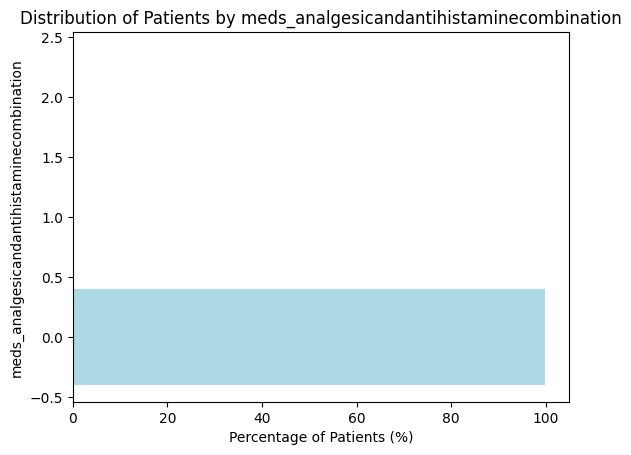

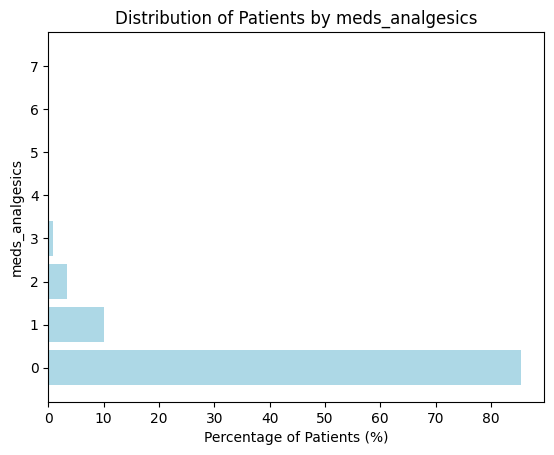

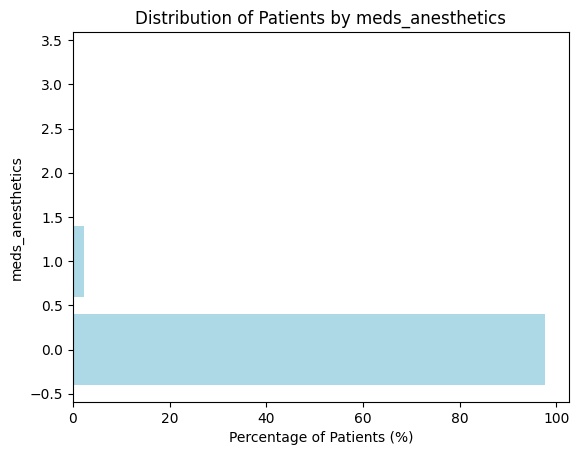

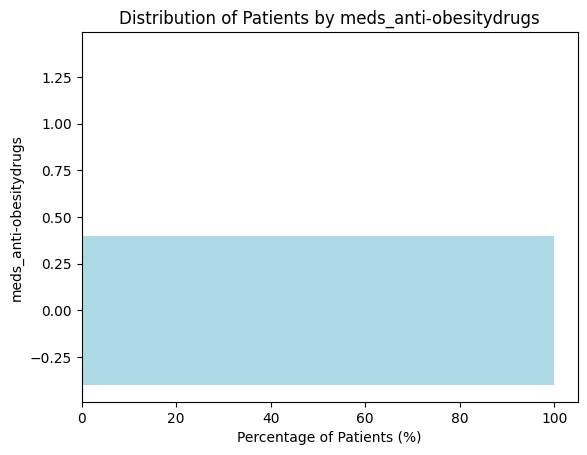

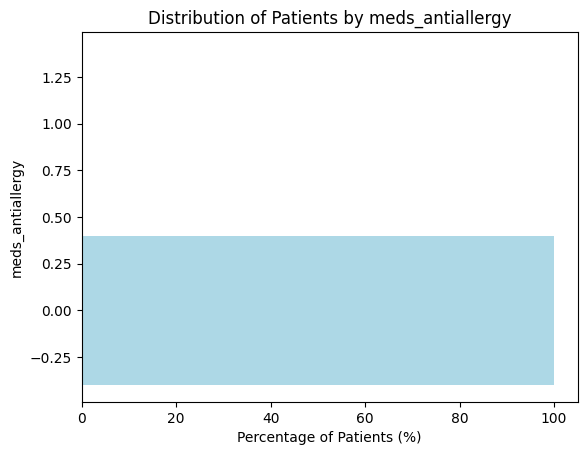

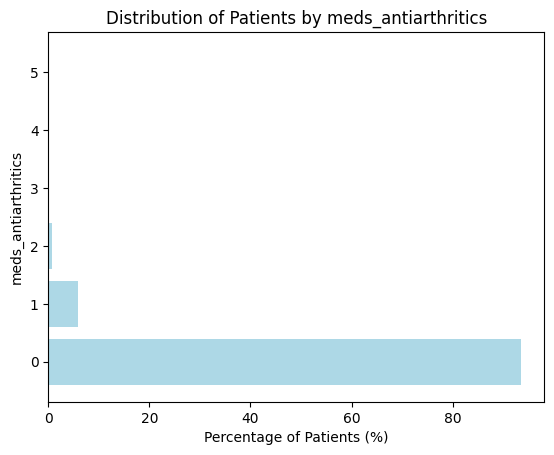

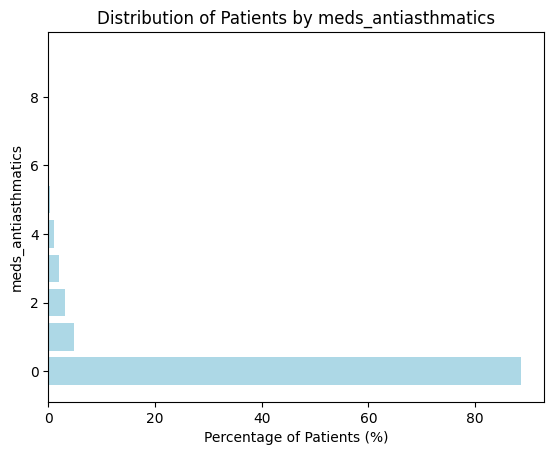

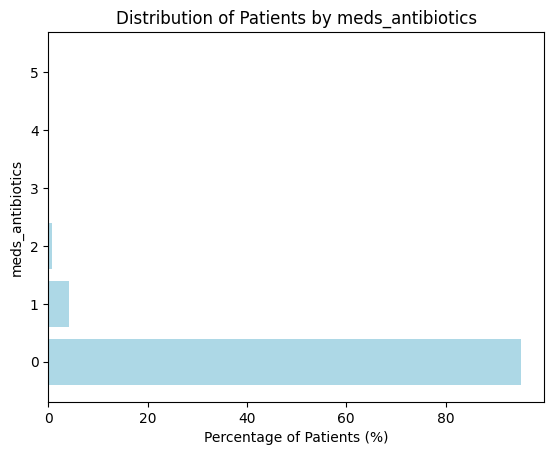

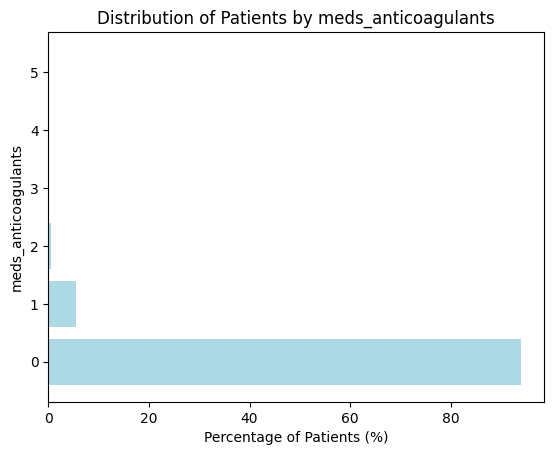

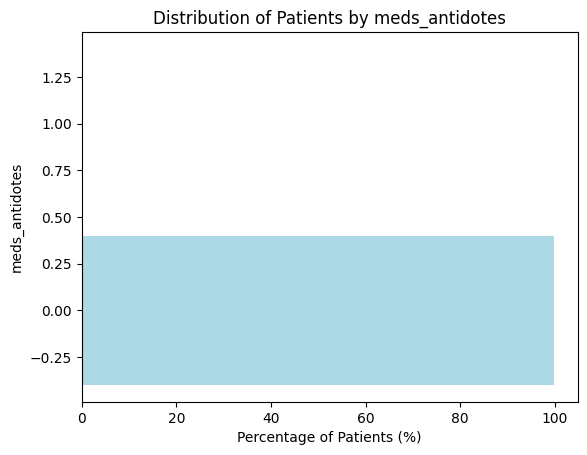

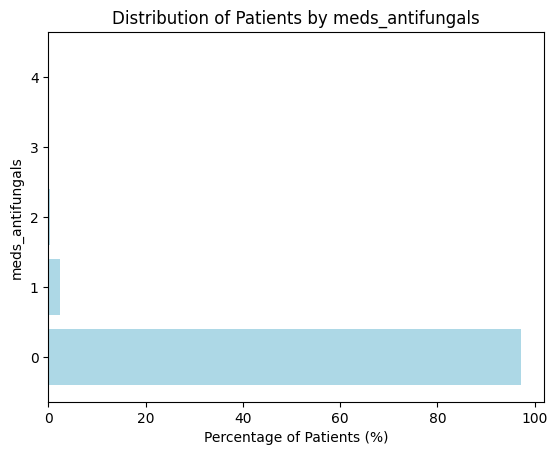

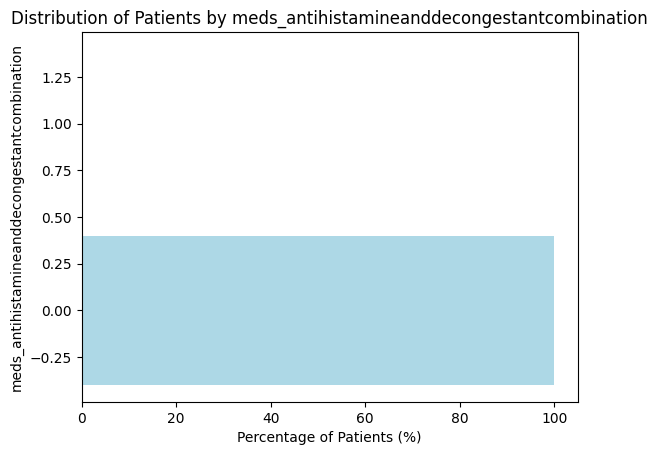

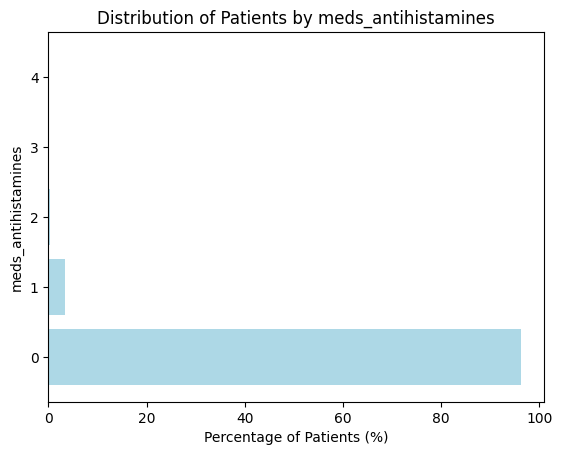

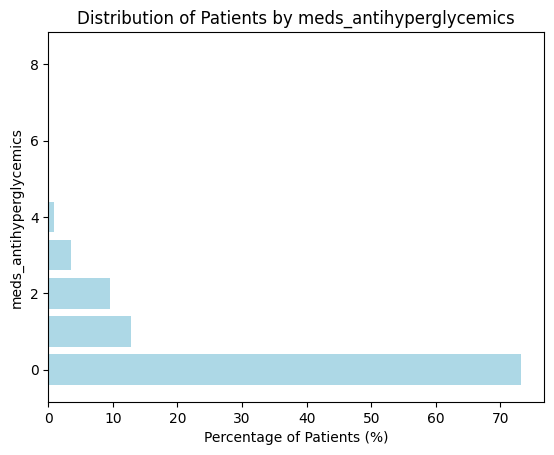

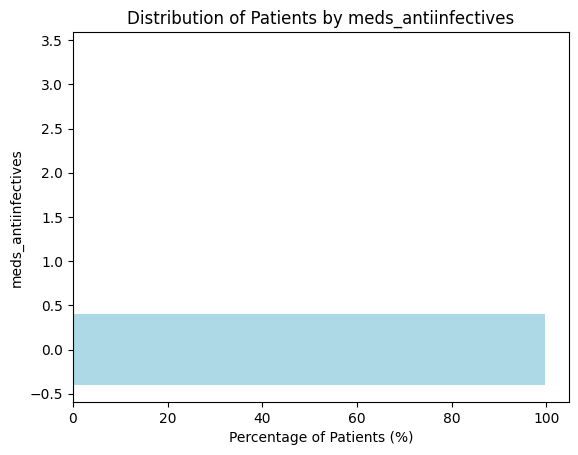

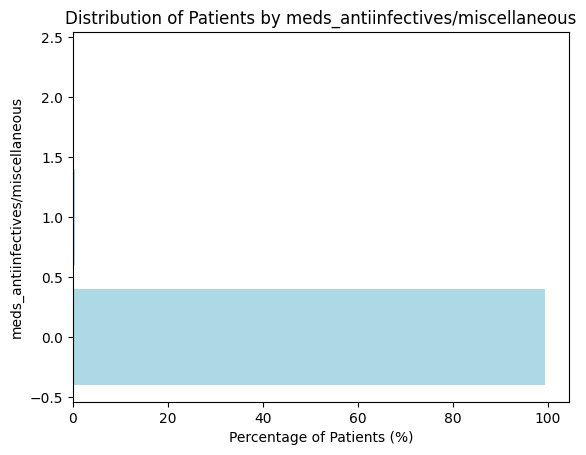

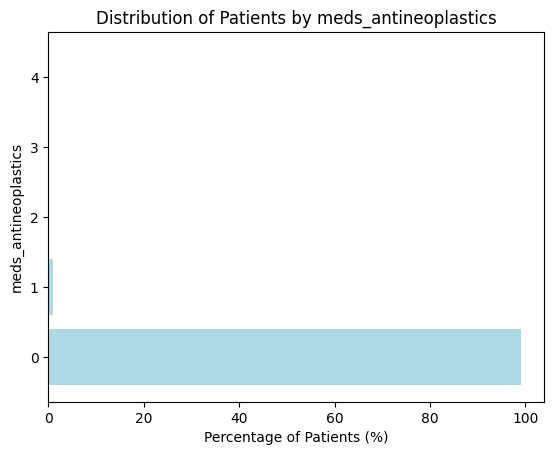

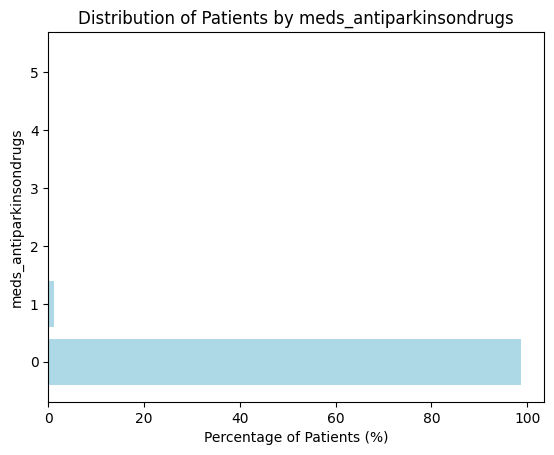

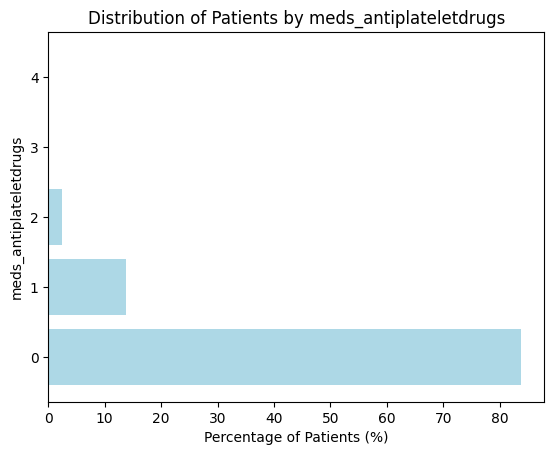

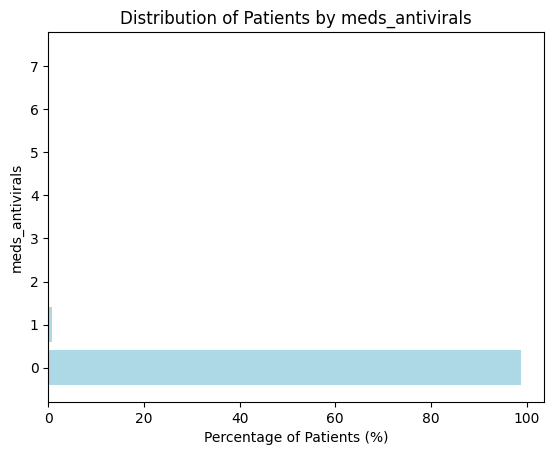

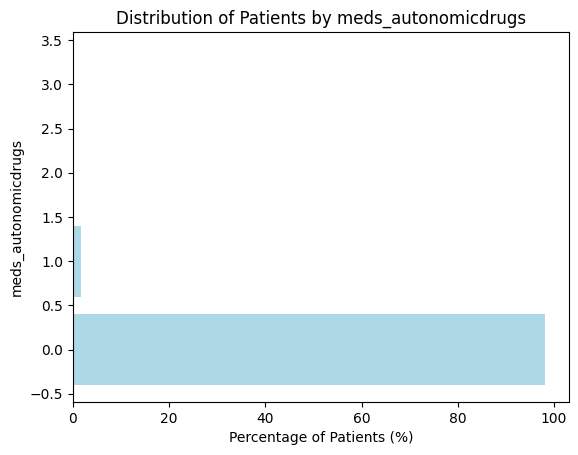

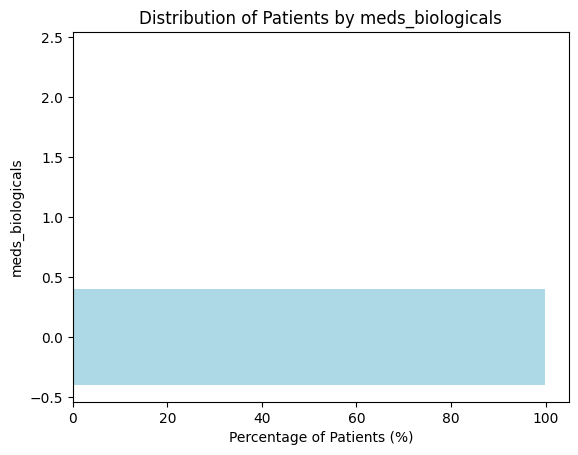

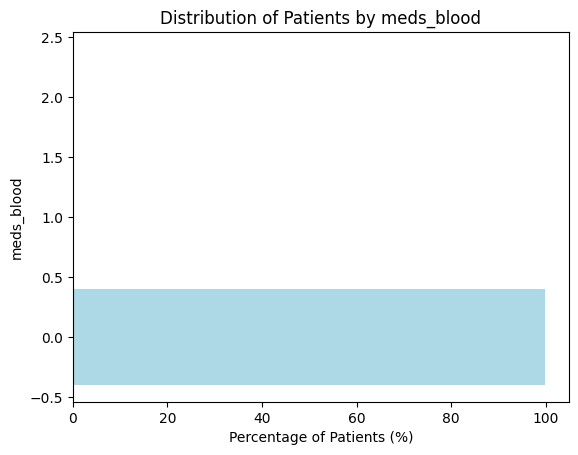

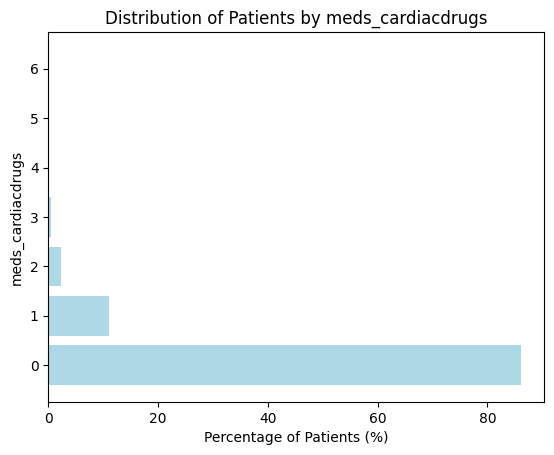

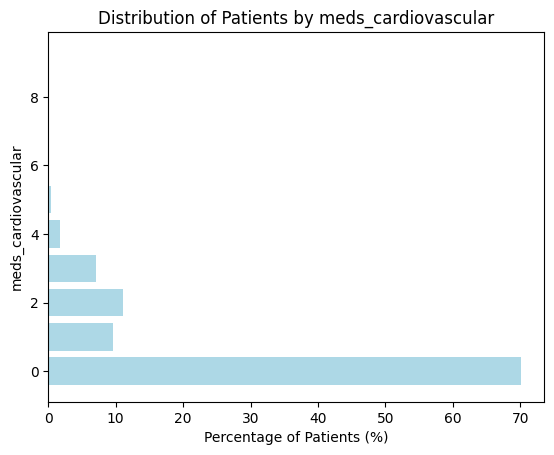

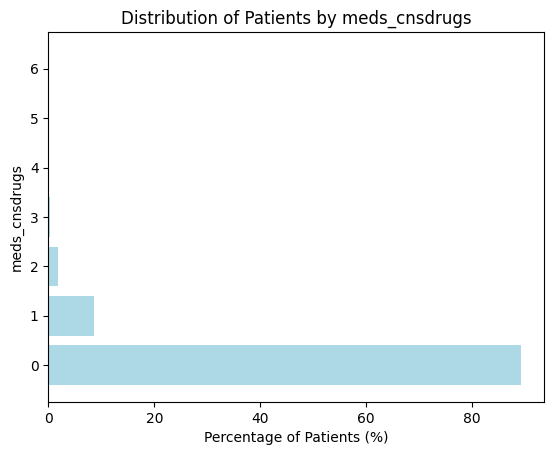

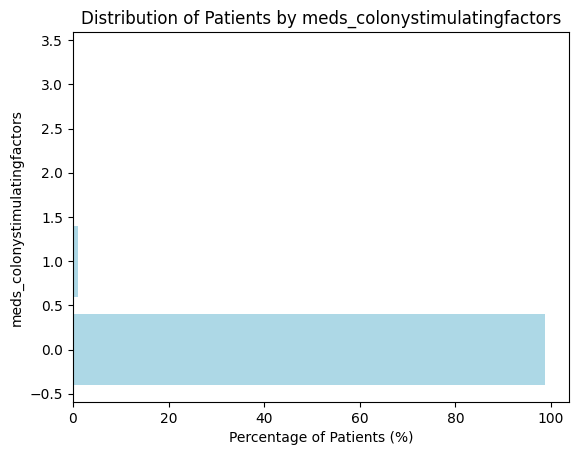

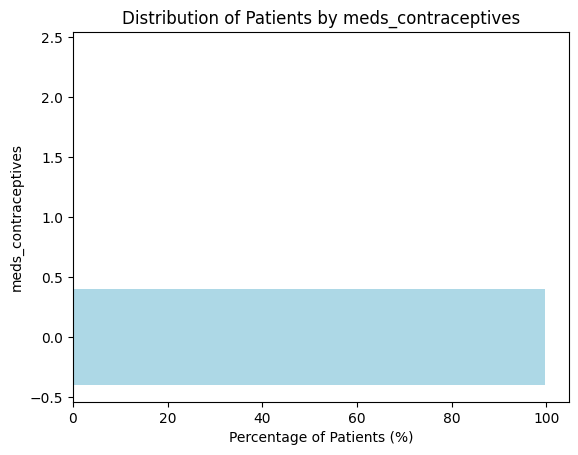

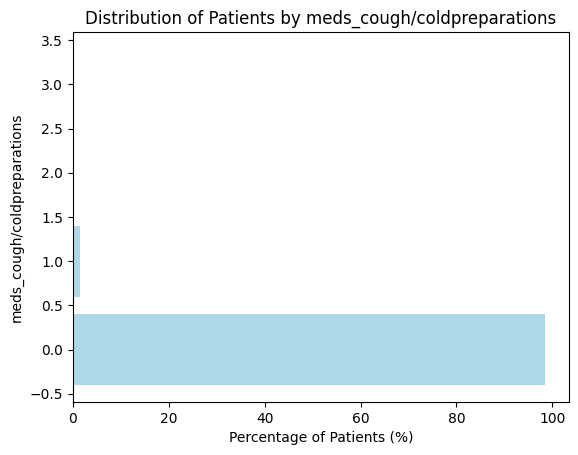

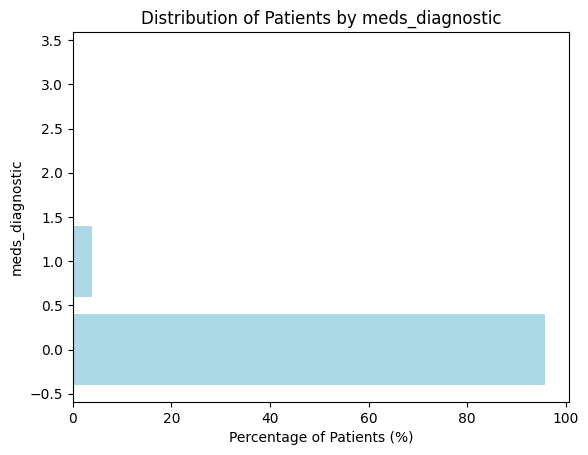

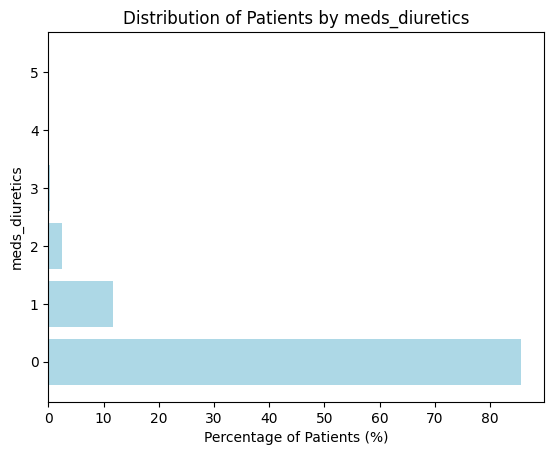

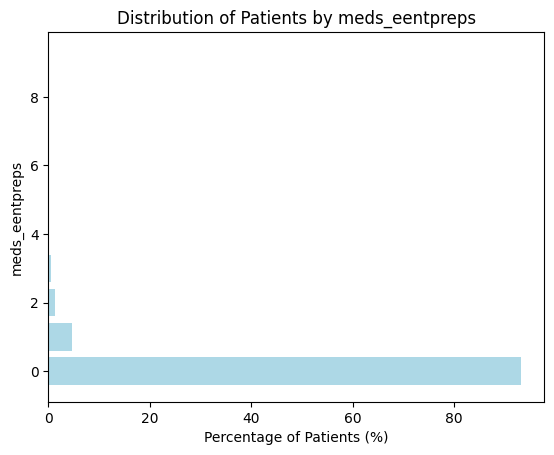

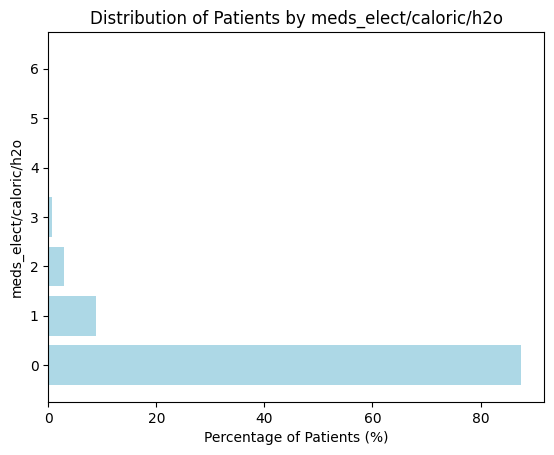

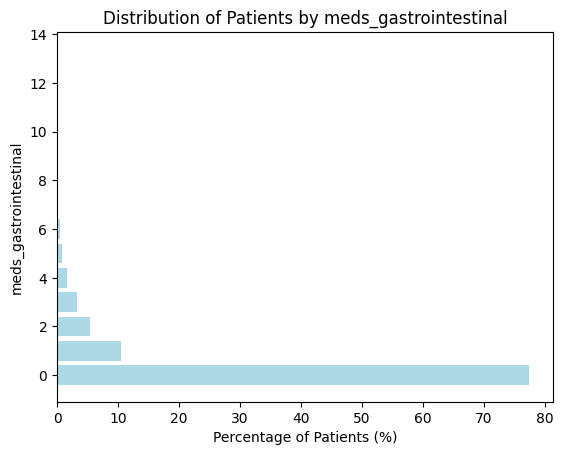

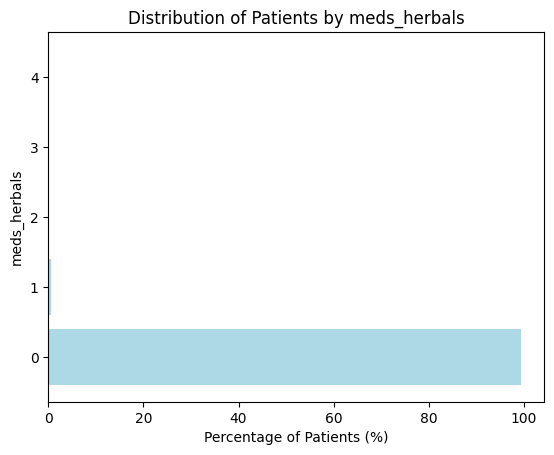

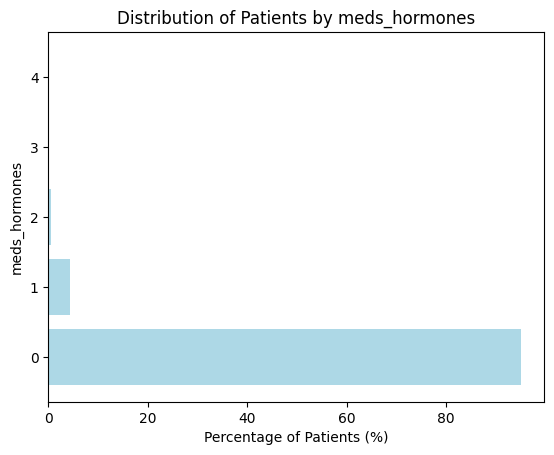

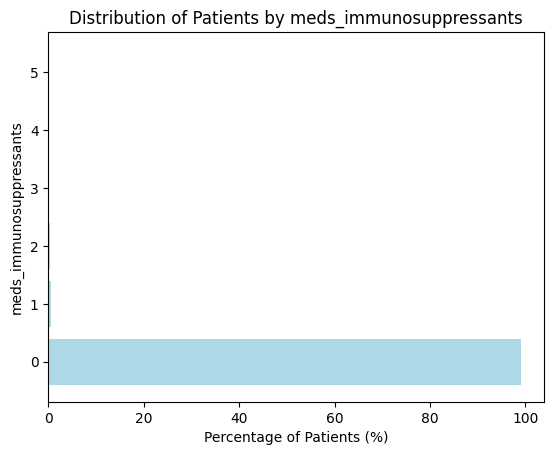

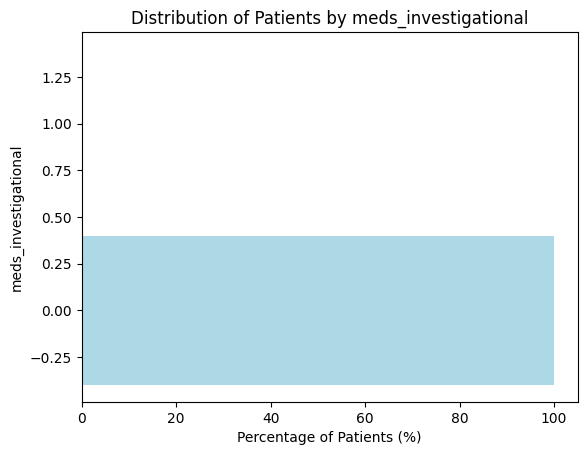

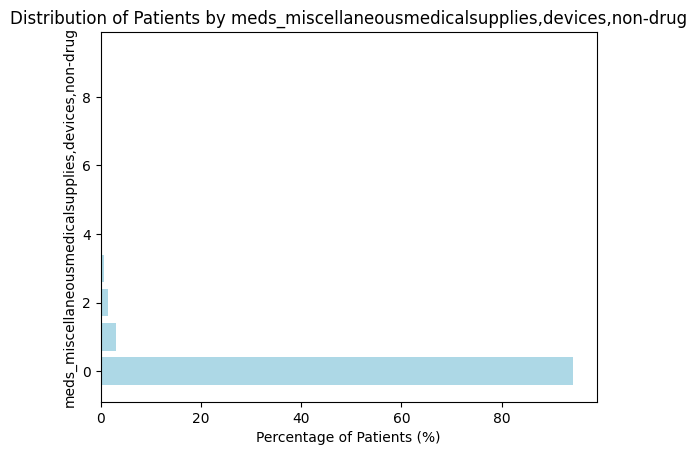

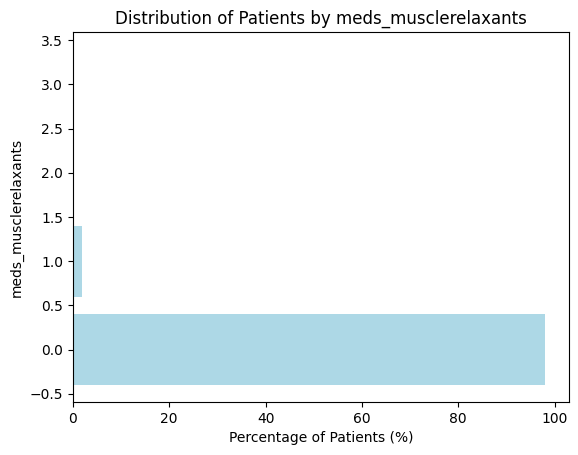

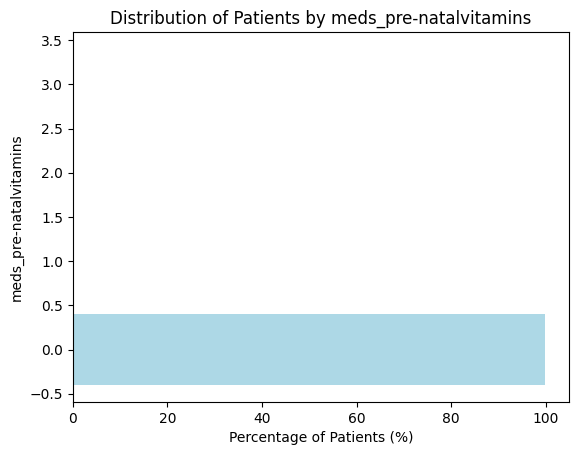

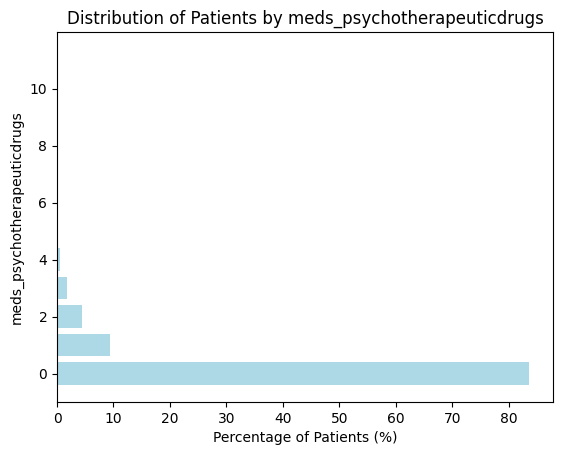

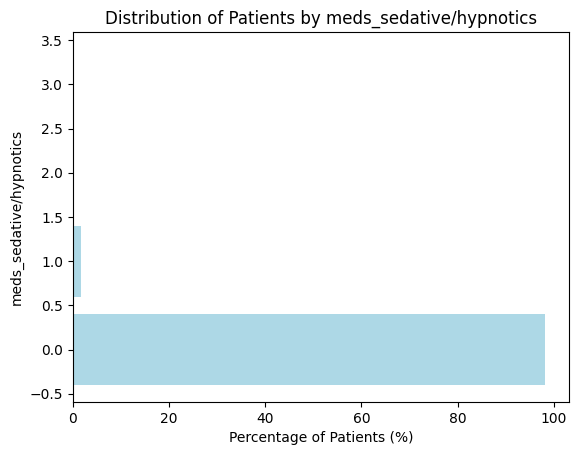

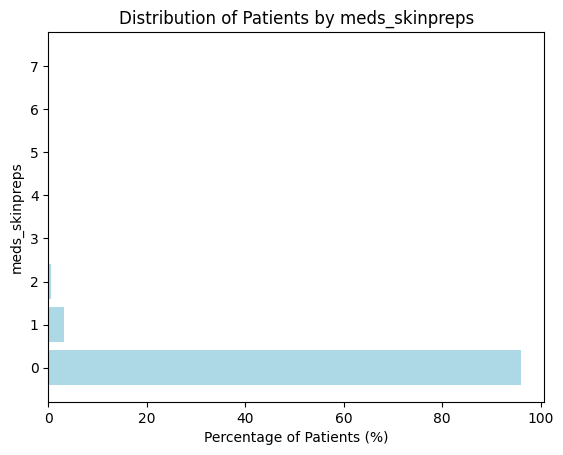

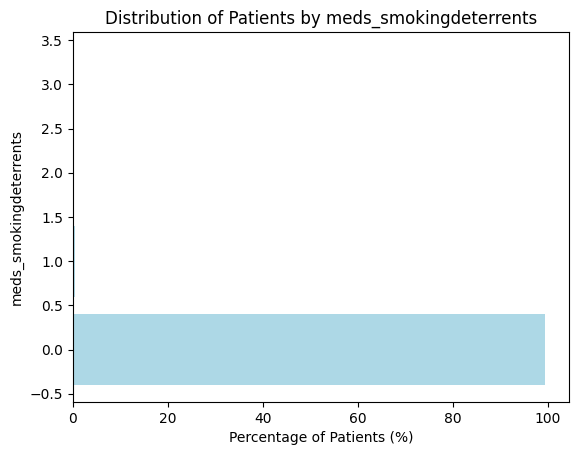

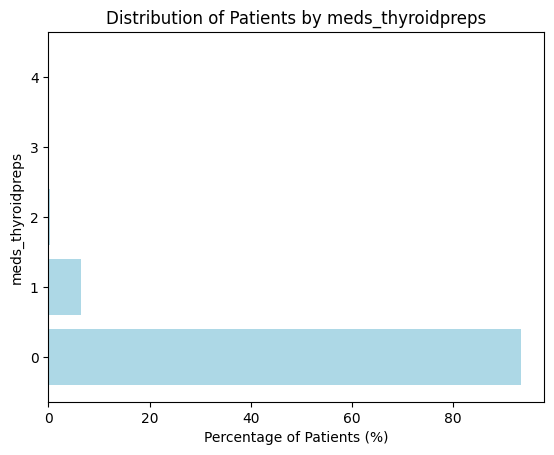

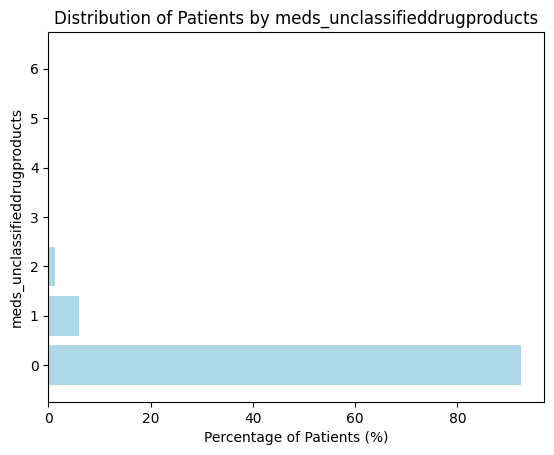

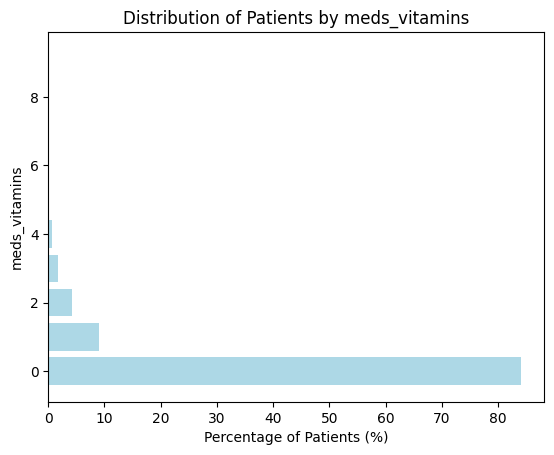

In [74]:

for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Create a bar chart to visualize the distribution by percentage
    plt.figure()
    plt.barh(percentages.index, percentages.values, color='lightblue')
    plt.ylabel(column)
    plt.xlabel('Percentage of Patients (%)')
    plt.title(f'Distribution of Patients by {column}')
    plt.show()

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `triage_cat` super column and disposition relate to each other. What is the likelihood of getting admitted based on these entries?

In [76]:
#Isolating columns of interest
columns_of_interest = meds


In [77]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Print the percentages
    print(f'Percentage Admission for {column}:')
    print(column_admission_percentage)
    print('\n')

Percentage Admission for meds_analgesicandantihistaminecombination:
meds_analgesicandantihistaminecombination
0.0    45.919007
1.0     0.090266
2.0     0.000950
dtype: float64


Percentage Admission for meds_analgesics:
meds_analgesics
0.0    32.830375
1.0     8.907871
2.0     3.267645
3.0     0.808597
4.0     0.152028
5.0     0.038007
6.0     0.004751
7.0     0.000950
dtype: float64


Percentage Admission for meds_anesthetics:
meds_anesthetics
0.0    43.897039
1.0     2.025769
2.0     0.082665
3.0     0.004751
dtype: float64


Percentage Admission for meds_anti-obesitydrugs:
meds_anti-obesitydrugs
0.0    45.989320
1.0     0.020904
dtype: float64


Percentage Admission for meds_antiallergy:
meds_antiallergy
0.0    46.009274
1.0     0.000950
dtype: float64


Percentage Admission for meds_antiarthritics:
meds_antiarthritics
0.0    40.425107
1.0     4.890540
2.0     0.622363
3.0     0.064612
4.0     0.006651
5.0     0.000950
dtype: float64


Percentage Admission for meds_antiasthmatics:
m

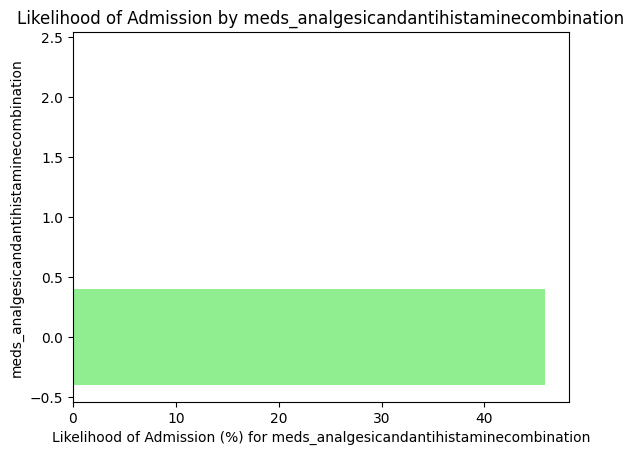

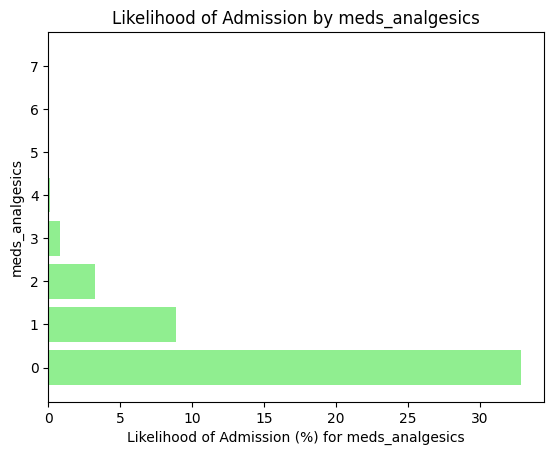

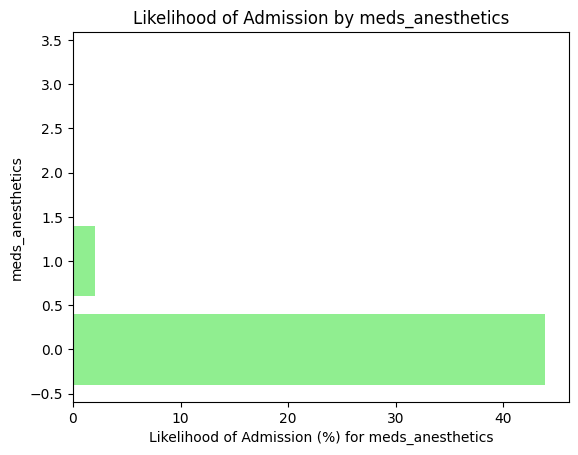

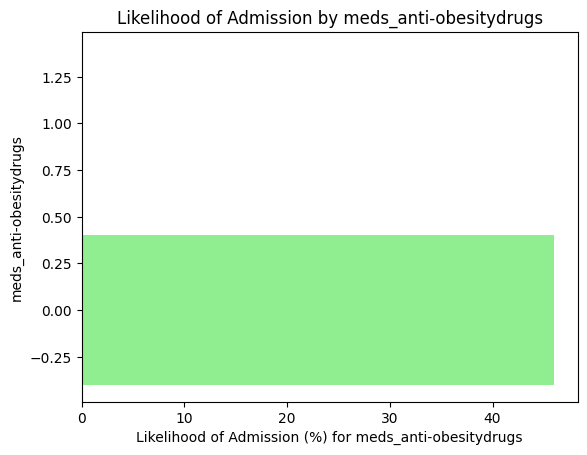

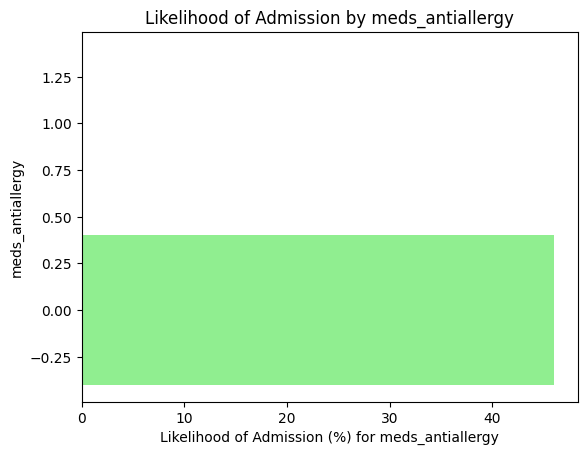

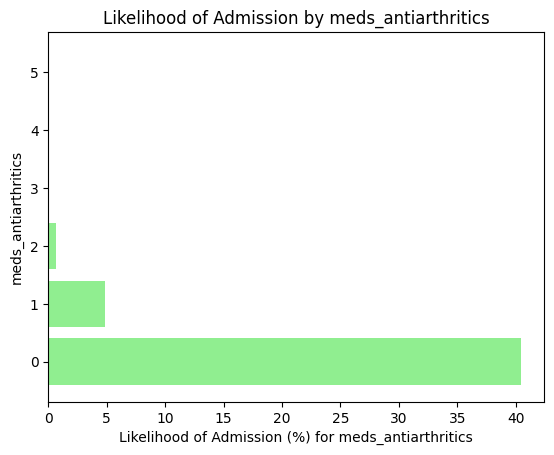

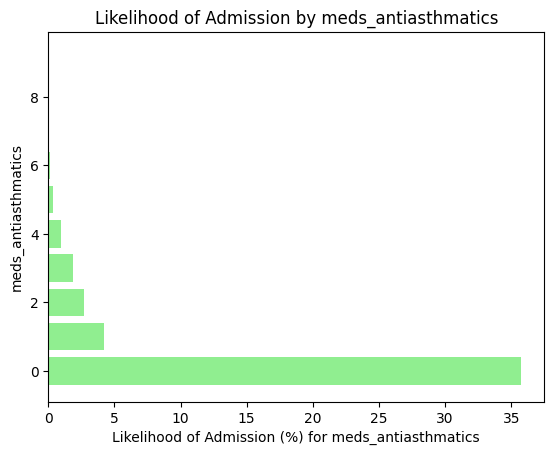

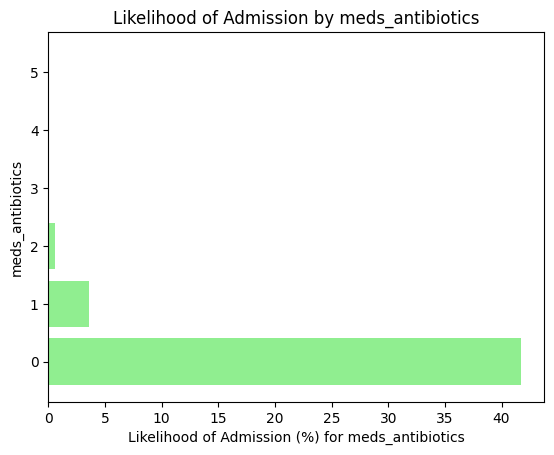

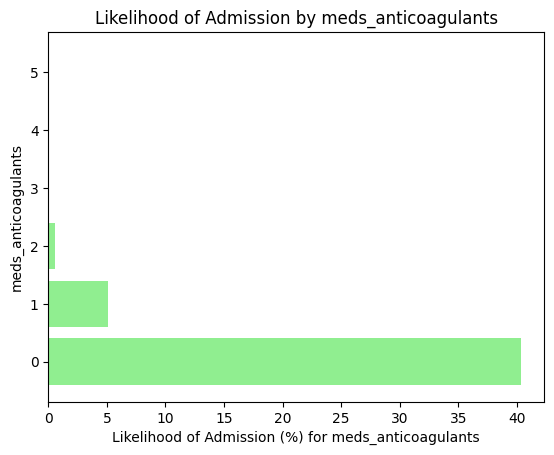

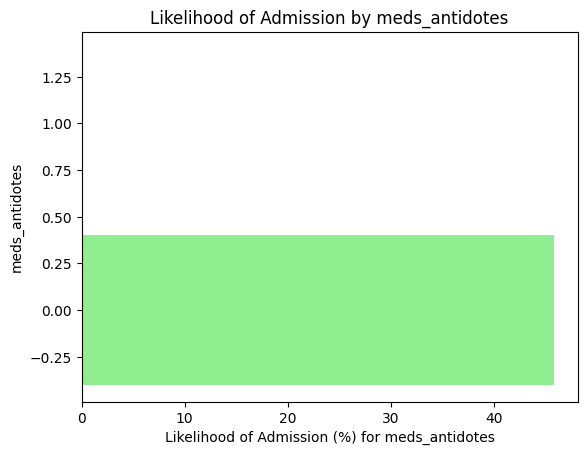

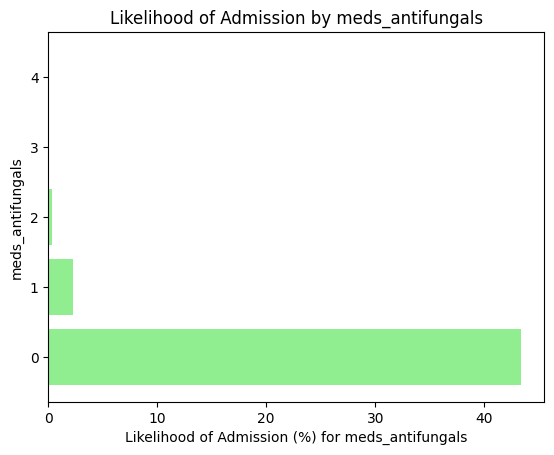

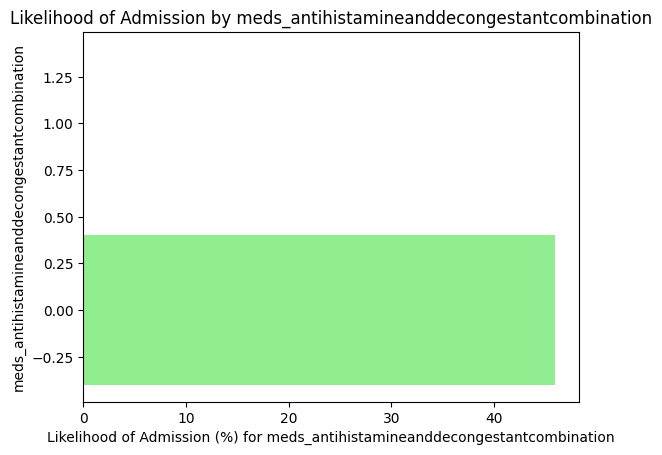

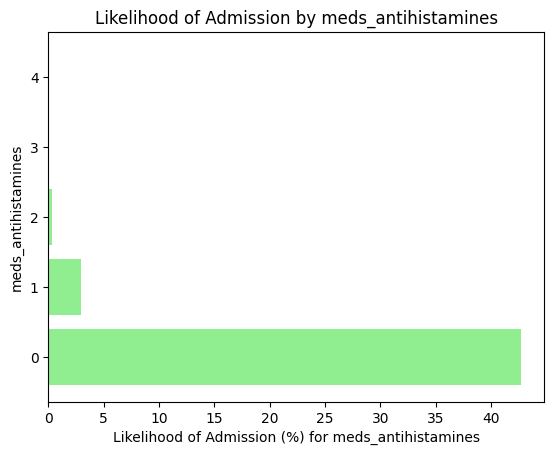

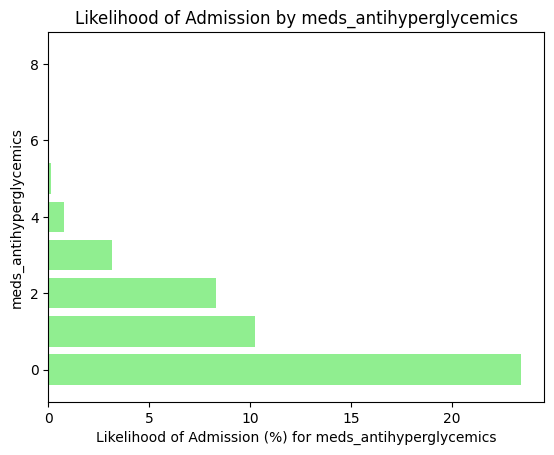

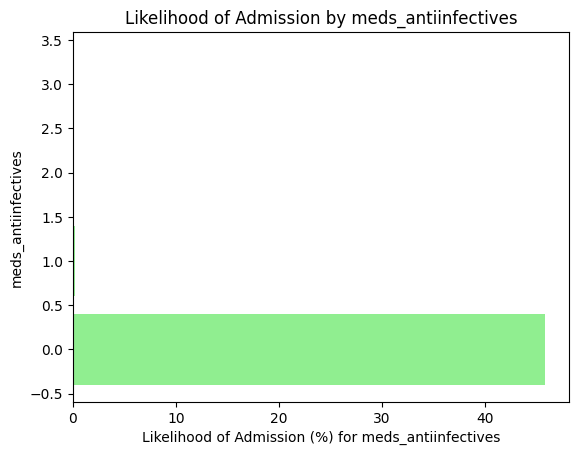

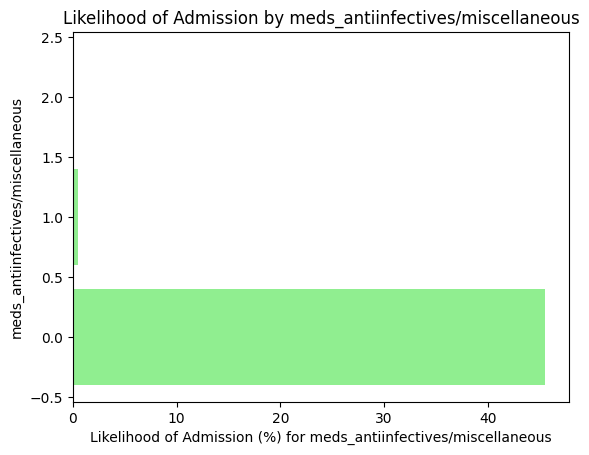

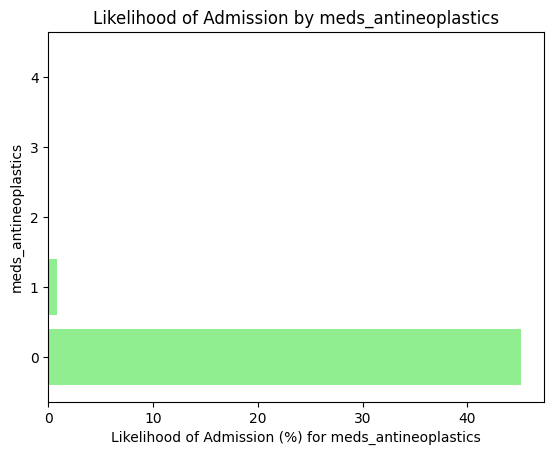

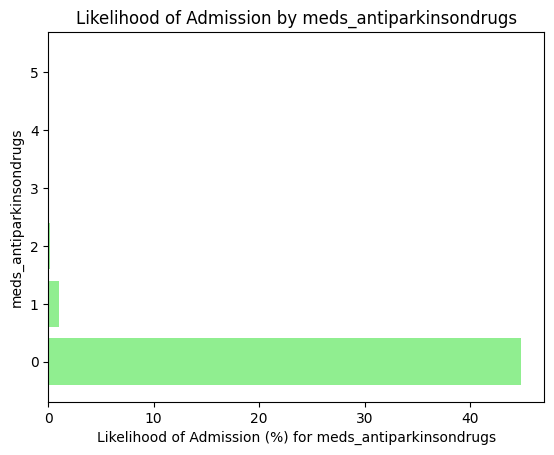

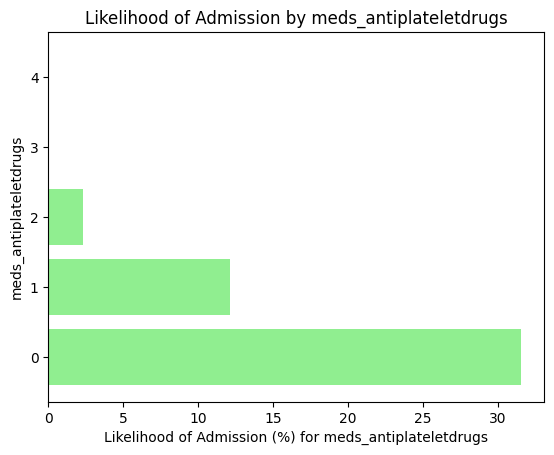

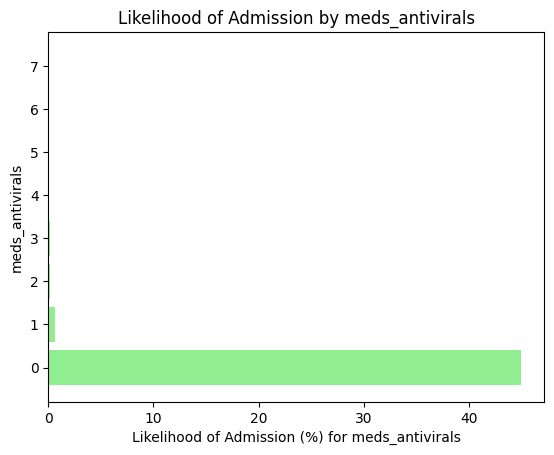

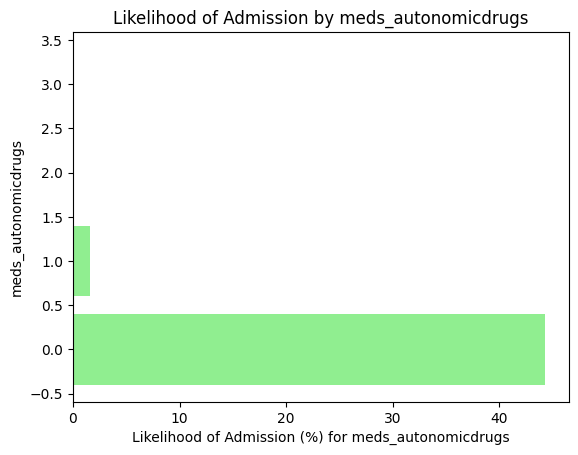

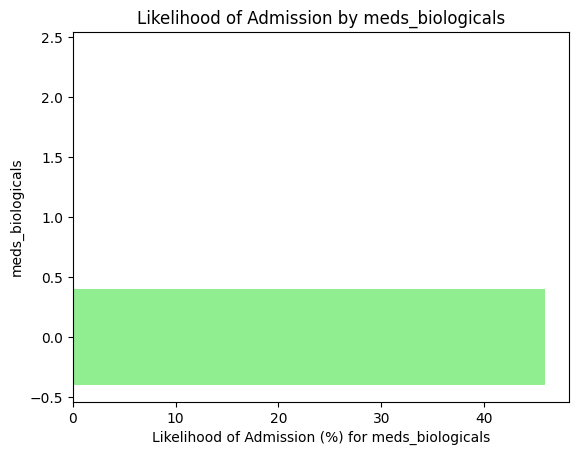

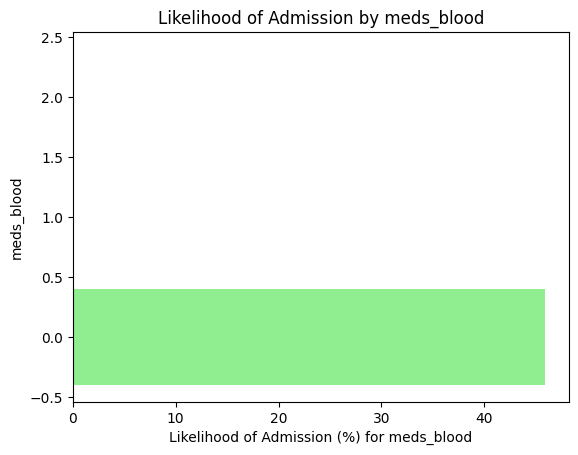

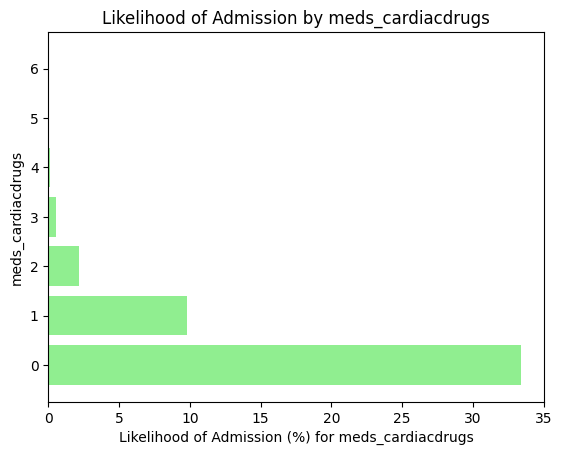

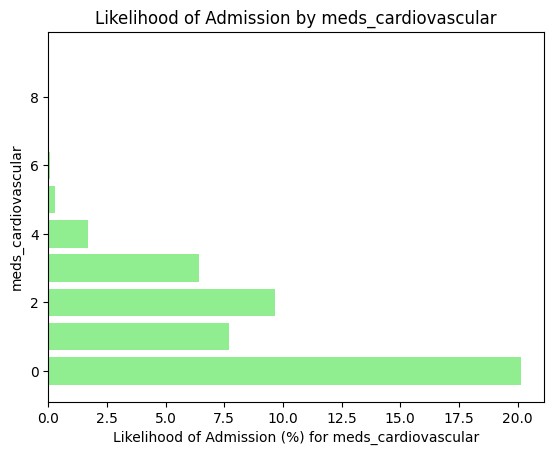

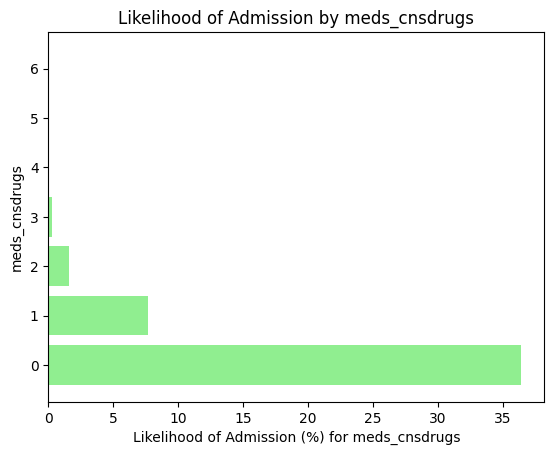

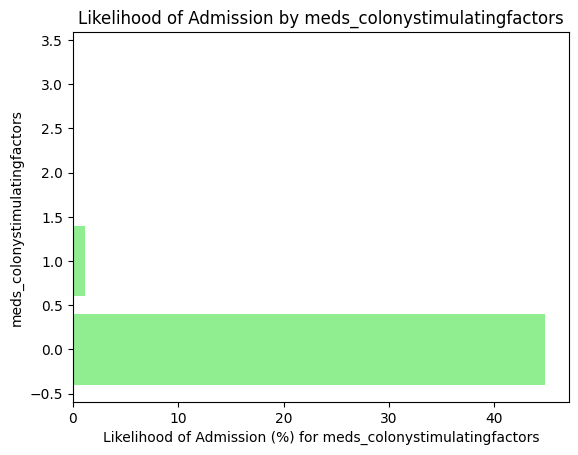

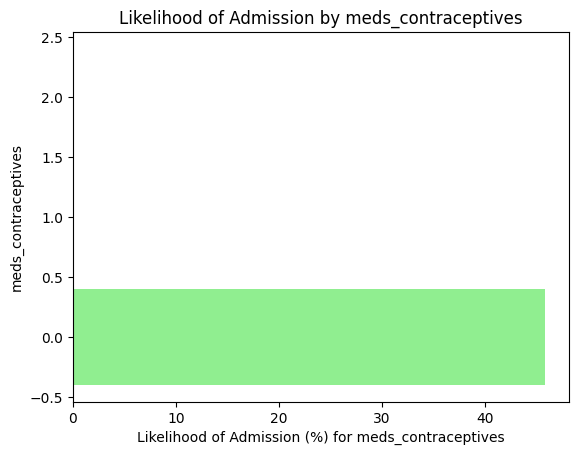

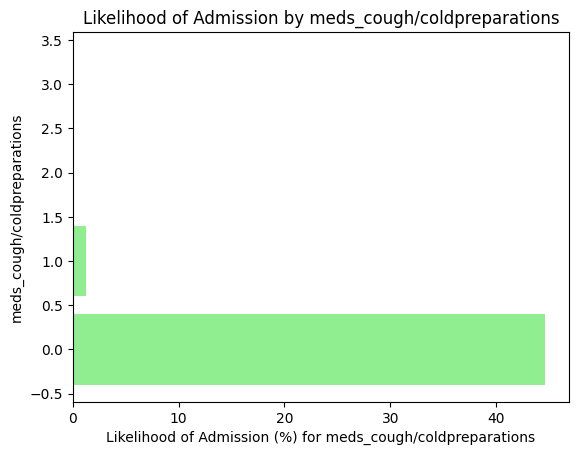

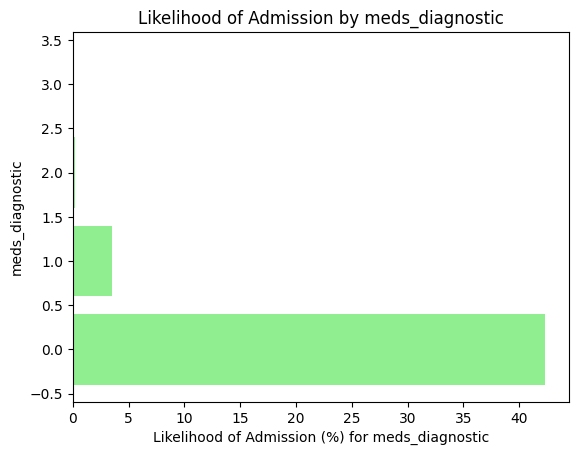

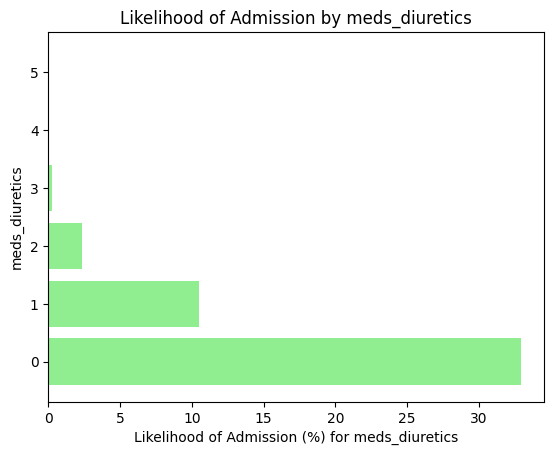

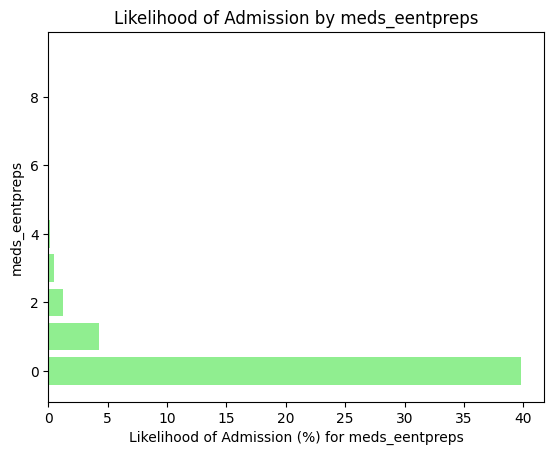

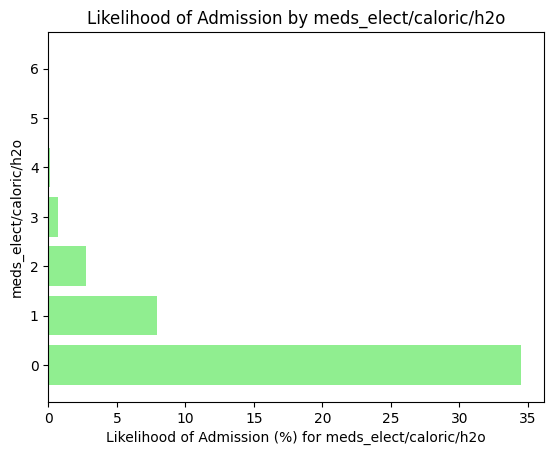

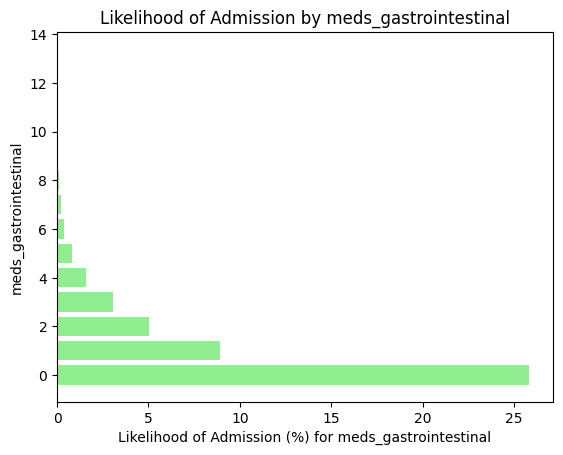

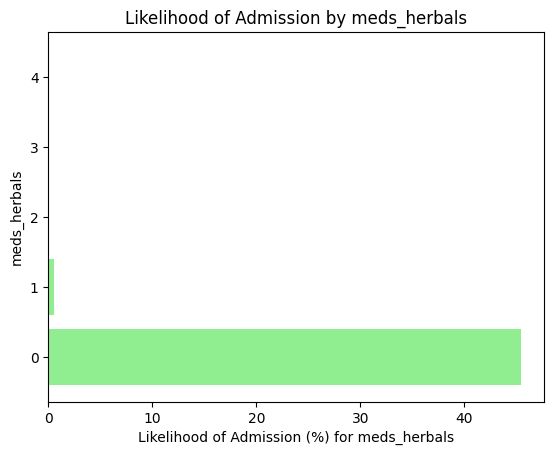

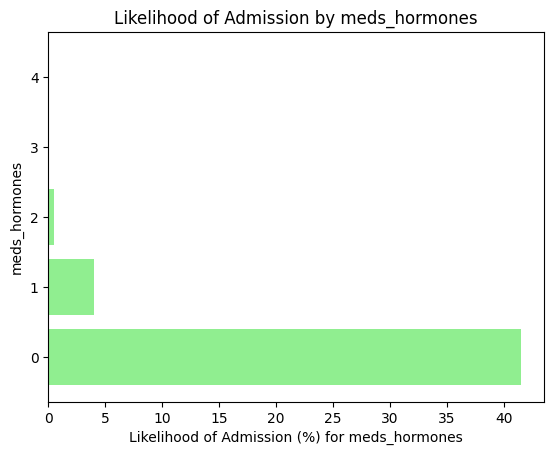

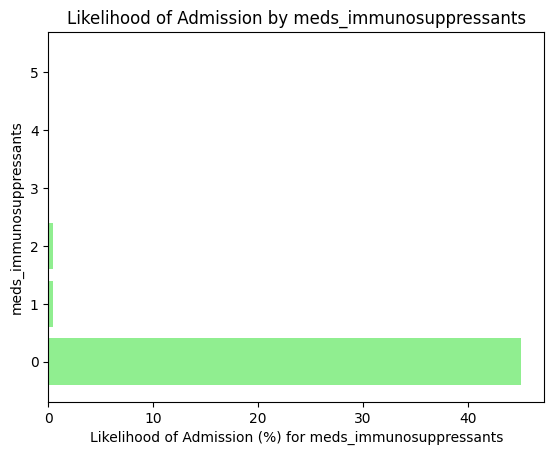

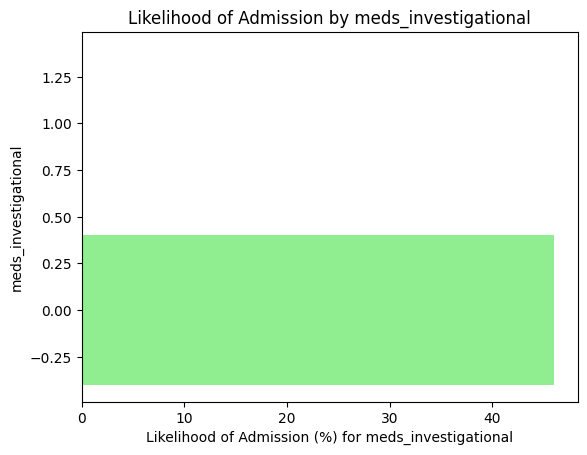

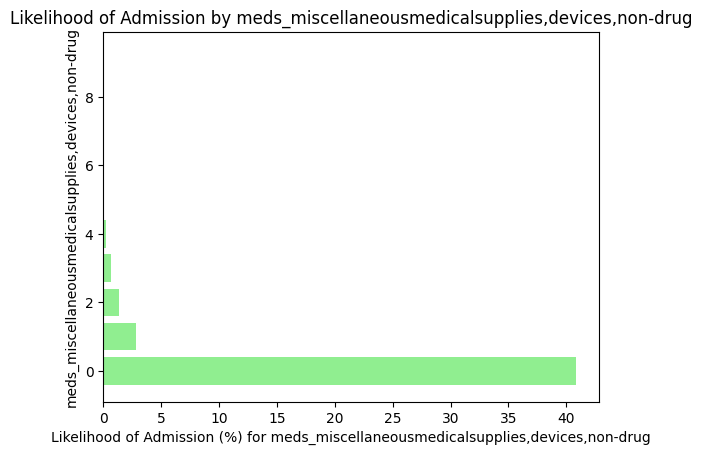

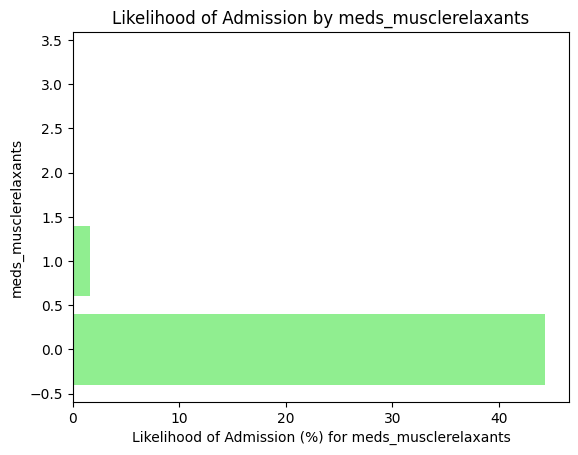

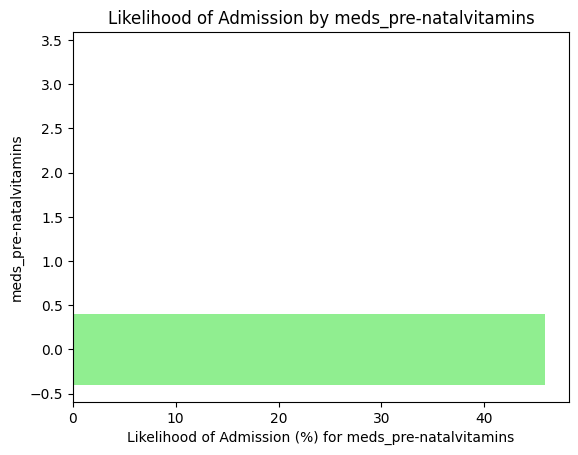

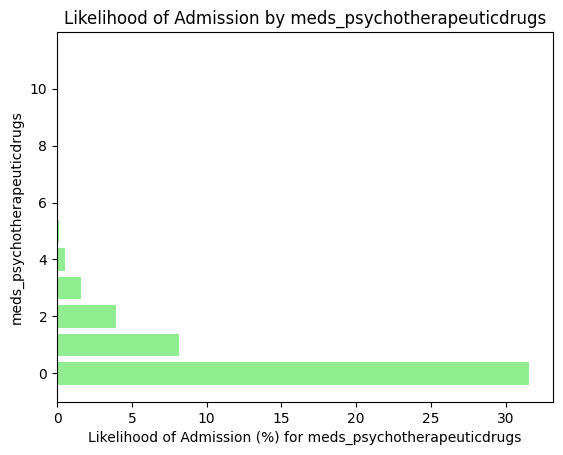

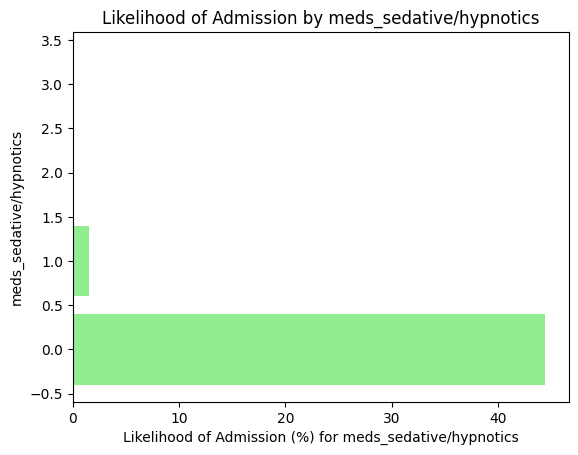

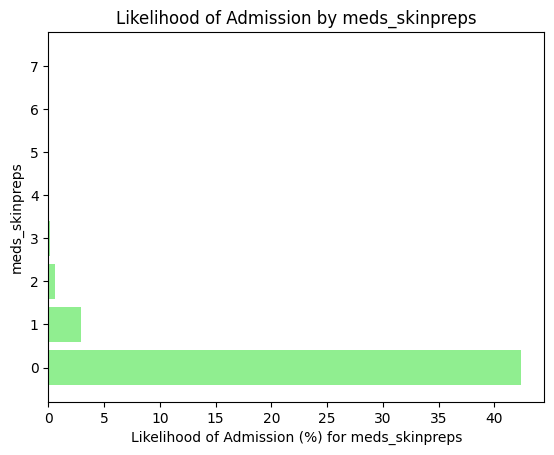

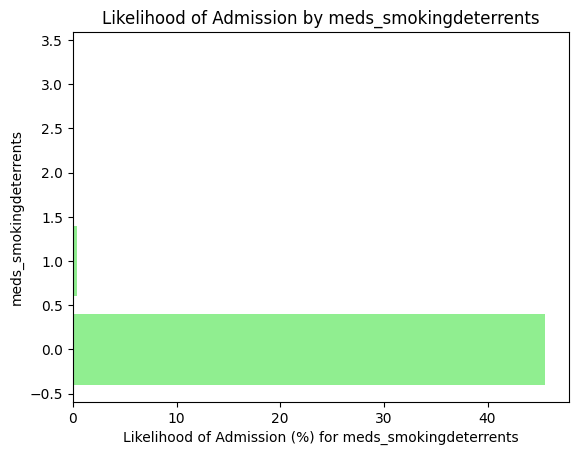

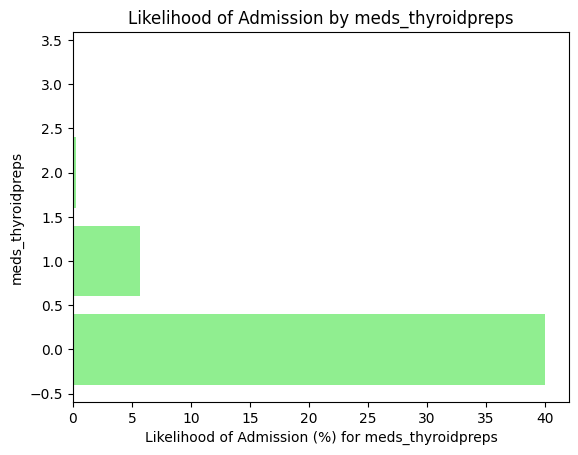

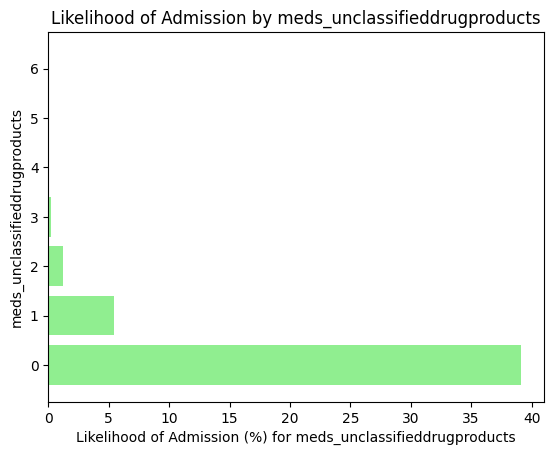

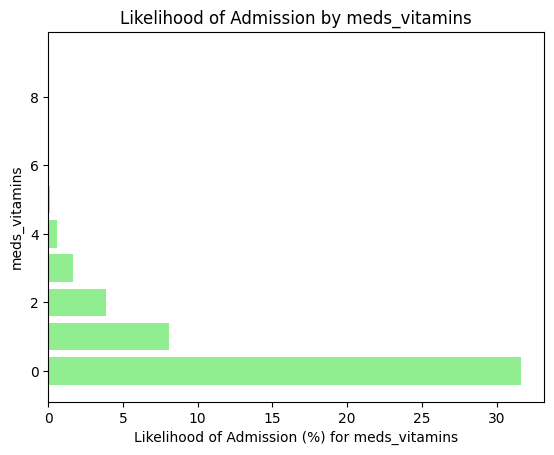

In [78]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Sort the results by admission percentage in descending order
    sorted_results = {k: v for k, v in sorted(column_admission_percentage.items(), key=lambda item: item[1], reverse=True)}

    # Extract data for the bar chart
    result = list(sorted_results.keys())
    admission_percentages = list(sorted_results.values())

    # Create and display the bar chart
    plt.figure()
    plt.barh(result, admission_percentages, color='lightgreen')
    plt.xlabel(f'Likelihood of Admission (%) for {column}')
    plt.ylabel(f'{column}')
    plt.title(f'Likelihood of Admission by {column}')
    plt.show()

We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Meds` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [79]:
#Establishing X and Y
X = health_data[meds]
Y = health_data['disposition']

In [80]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


                                            Variable1     ChiSquare  \
0           meds_analgesicandantihistaminecombination     87.310835   
1                                     meds_analgesics  14164.900057   
2                                    meds_anesthetics   2129.071540   
3                              meds_anti-obesitydrugs      3.350598   
4                                    meds_antiallergy      0.006408   
5                                 meds_antiarthritics   4591.347392   
6                                 meds_antiasthmatics  10524.882116   
7                                    meds_antibiotics   3954.148121   
8                                 meds_anticoagulants   6111.216388   
9                                      meds_antidotes    113.232761   
10                                   meds_antifungals   2700.002431   
11       meds_antihistamineanddecongestantcombination     25.685997   
12                                meds_antihistamines   2863.371882   
13    

In [82]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

sorted_df

Variable1     ChiSquare  \
24                                meds_cardiovascular  29822.778037   
33                              meds_gastrointestinal  23614.596656   
13                            meds_antihyperglycemics  22848.442155   
47                                      meds_vitamins  15735.376795   
18                             meds_antiplateletdrugs  15304.189751   
41                        meds_psychotherapeuticdrugs  14860.715355   
30                                     meds_diuretics  14254.034971   
1                                     meds_analgesics  14164.900057   
23                                  meds_cardiacdrugs  13775.747942   
32                             meds_elect/caloric/h2o  12816.475629   
6                                 meds_antiasthmatics  10524.882116   
25                                      meds_cnsdrugs   9448.482403   
46                      meds_unclassifieddrugproducts   6949.247827   
31                                     meds_eentpreps   6176.508808   
8                                 meds_anticoagulants   6111.216388   
45                                  meds_thyroidpreps   5788.523905   
38  meds_miscellaneousmedicalsupplies,devices,non-...   4993.489172   
5                                 meds_antiarthritics   4591.347392   
35                                      meds_hormones   4513.987547   
7                                    meds_antibiotics   3954.148121   
43                                     meds_skinpreps   3468.621567   
29                                    meds_diagnostic   3321.375063   
12                                meds_antihistamines   2863.371882   
10                                   meds_antifungals   2700.002431   
2                                    meds_anesthetics   2129.071540   
20                                meds_autonomicdrugs   1754.591090   
42                            meds_sedative/hypnotics   1363.624888   
39                               meds_musclerelaxants   1353.836734   
26                      meds_colonystimulatingfactors   1346.807795   
28                        meds_cough/coldpreparations   1337.846616   
17                            meds_antiparkinsondrugs   1024.978583   
36                            meds_immunosuppressants   1020.197400   
19                                    meds_antivirals    971.999063   
16                               meds_antineoplastics    962.504919   
34                                       meds_herbals    548.805582   
15                  meds_antiinfectives/miscellaneous    467.533633   
44                             meds_smokingdeterrents    402.839793   
14                                meds_antiinfectives    207.495301   
9                                      meds_antidotes    113.232761   
0           meds_analgesicandantihistaminecombination     87.310835   
22                                         meds_blood     67.137157   
21                                   meds_biologicals     54.001382   
27                                meds_contraceptives     25.694538   
11       meds_antihistamineanddecongestantcombination     25.685997   
40                             meds_pre-natalvitamins     18.461629   
37                               meds_investigational      3.999663   

          P_Value  
24   0.000000e+00  
33   0.000000e+00  
13   0.000000e+00  
47   0.000000e+00  
18   0.000000e+00  
41   0.000000e+00  
30   0.000000e+00  
1    0.000000e+00  
23   0.000000e+00  
32   0.000000e+00  
6    0.000000e+00  
25   0.000000e+00  
46   0.000000e+00  
31   0.000000e+00  
8    0.000000e+00  
45   0.000000e+00  
38   0.000000e+00  
5    0.000000e+00  
35   0.000000e+00  
7    0.000000e+00  
43   0.000000e+00  
29   0.000000e+00  
12   0.000000e+00  
10   0.000000e+00  
2    0.000000e+00  
20   0.000000e+00  
42  2.302627e-295  
39  3.062895e-293  
26  1.026404e-291  
28  9.031627e-290  
17  2.349039e-219  
36  2.547246e-218  
19  1.350000e-205  
16  4.764165e-207  
34  1.

---
Key takeaways: 

---
#### <a id = 'tcat'></a> 1.9 Disposition vs Median Glucose Reading

Let's first learn a little bit more about our demographic data. Let's first start by seeing what columns belong to the `'hist_glucose_median'`column. 

In [94]:
hist_glu = ['hist_glucose_median']

First, let's look into what kind of data lives here. 
- What is the distribution?
- What is the relationship to disposition?  
----

What is the distribution?
`'hist_glucose_median'`column. What are the percentages of each unique entry from the whole? What is the distribution?

In [95]:
# Define the list of columns to analyze
columns_of_interest = hist_glu

In [96]:
for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Print the percentages
    print(f'Percentage Distribution for {column}:')
    print(percentages)
    print('\n')

Percentage Distribution for hist_glucose_median:
hist_glucose_median
Normal             77.013416
>200(high)         15.814678
>300(very high)     7.171905
Name: count, dtype: float64




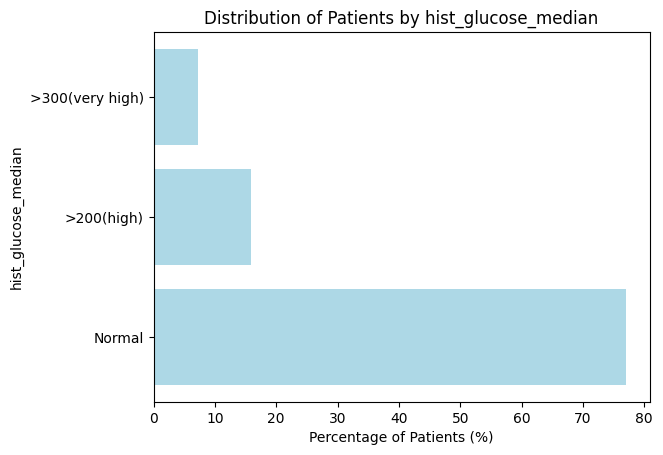

In [97]:

for column in columns_of_interest:
    column_data = health_data[column]
    column_counts = column_data.value_counts()
    total_count = len(column_data)
    
    # Calculate the percentage for each category
    percentages = (column_counts / total_count)*100
    
    # Create a bar chart to visualize the distribution by percentage
    plt.figure()
    plt.barh(percentages.index, percentages.values, color='lightblue')
    plt.ylabel(column)
    plt.xlabel('Percentage of Patients (%)')
    plt.title(f'Distribution of Patients by {column}')
    plt.show()

---
What is the relationship between disposition and these variables?

Here we will look at how the unique entries live in the different columns in the `hist_glucose_median` column and disposition relate to each other. What is the likelihood of getting admitted based on these entries?

In [98]:
#Isolating columns of interest
columns_of_interest = hist_glu


In [99]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Print the percentages
    print(f'Percentage Admission for {column}:')
    print(column_admission_percentage)
    print('\n')

Percentage Admission for hist_glucose_median:
hist_glucose_median
>200(high)          7.026529
>300(very high)     3.454829
Normal             35.528866
dtype: float64




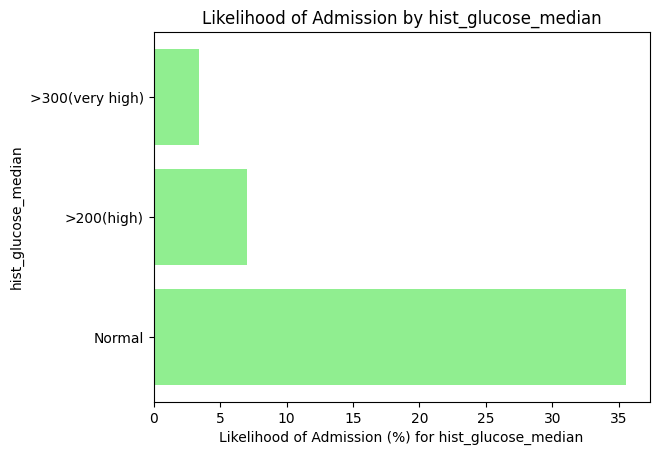

In [100]:
for column in columns_of_interest:
    column_disposition_df = health_data[[column, 'disposition']]
    
    # Getting number of admissions per column entry
    column_admissions = column_disposition_df[column_disposition_df['disposition'] == 1].groupby(column).size()
    
    # Getting the total size of the entire dataset
    total_population = len(health_data)
    
    # Calculate the percentage admission rate for each category relative to the total population
    column_admission_percentage = (column_admissions / total_population) * 100

    # Sort the results by admission percentage in descending order
    sorted_results = {k: v for k, v in sorted(column_admission_percentage.items(), key=lambda item: item[1], reverse=True)}

    # Extract data for the bar chart
    result = list(sorted_results.keys())
    admission_percentages = list(sorted_results.values())

    # Create and display the bar chart
    plt.figure()
    plt.barh(result, admission_percentages, color='lightgreen')
    plt.xlabel(f'Likelihood of Admission (%) for {column}')
    plt.ylabel(f'{column}')
    plt.title(f'Likelihood of Admission by {column}')
    plt.show()

We will be using the chi-square test for independence given that the x columns are categorical and the y column is binary. This test should tell us if any association between the target and the features.  We will look at the coefficient to determine the relationship that exists between the given `Triage Categorical` column and the target column `disposition` as well as a the p-value. We will look at those columns that have a p-value of less than 0.05. 

In [104]:
#Establishing X and Y
X = health_data[hist_glu]
Y = health_data['disposition']

In [105]:
# List of binary columns
binary_columns = X.columns.tolist() 

# Create an empty list to store the results
results = []

# Iterate through pairs of a binary column and the target column
for col in binary_columns:

    # Create a contingency table
    contingency_table = pd.crosstab(X[col], Y)

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append the results to the list
    results.append({'Variable1': col, 'ChiSquare': chi2, 'P_Value': p})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


             Variable1  ChiSquare       P_Value
0  hist_glucose_median  31.412936  1.509272e-07


In [106]:
# Filter rows with P_Value less than 0.05
filtered_df = results_df[results_df['P_Value'] < 0.05]

# Sort the filtered DataFrame by P_Value in descending order
sorted_df = filtered_df.sort_values(by='ChiSquare', ascending=False)

print(sorted_df)

             Variable1  ChiSquare       P_Value
0  hist_glucose_median  31.412936  1.509272e-07


---
Key takeaways: 